# Chapter 1 : セレクションバイアスとRCT
### Agenda

- ATEとRCT
- RCTとcovariatesの分布確認
- Potential outcome framework


## Package Install

In [1]:
pass

## ライブラリの読み込み

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest

## 1.1 なぜ因果推論が重要なのか

日々の意思決定は、（予算などの企業資源の制約から）与えられた選択肢のうち一つしか実行できないがどれを実行すべきなのか？という形に落とし込まれる場合が多い。このとき、

- 自分の目的関数
- 各選択肢の目的関数に対する効果

を踏まえて意思決定する。ビジネスシーンでの「自分の目的関数」は事業利益が代表的な例。


各施策の効果が分からないと利益最大化に適った意思決定することは難しい。因果推論とはこの効果及びその程度の推論を通して、企業の意思決定を適切な方向に向けて舵取りをすることに役に立つ分野。


### 再現性と因果関係

因果推論で常に意識すべきこととして「再現性」が挙げられる。これは意思決定する場面で推定した効果が再現されるのかと理解している。


### Causal Graph

自分が検討している施策の効果の再現性を考えるあたり、仮説ベースでその施策が目的関数に影響を与えるまでのPath、

- Causal Graph

を書いてみる。例えば、「ユーザーに商品をApp pushで宣伝することでECサイトでの購買を促がし、利潤が上昇する」という施策を考える場合、

```
App push → push messageを開封する → お勧めされた商品ページをみる → カートに入れる → 購買する → 利潤が上がる
```
というPath。こういうPathを描くことで、以下のメリットを享受できる：

- App pushという施策が企業利潤に影響を本当に与えているのか？そのメカニズムは？を明確にビジネスパーソンに伝えることができる
- その施策の妥当性を企画段階から議論もできる
- いわゆるABテストでrobustness checkをしながら検定が可能となる（＝再現性を高める）
- 後々のKPI/Metrics設定を通じたモニタリングにも活用できる

#### 例：Causal Graph

<img src= "https://github.com/RyoNakagami/omorikaizuka/blob/master/Econometrics/causal_graph.jpg?raw=true">


#### Causal pathとestimatorの関係

- condition on variables, i.e. matching and regression-based estimation
- exogenous variation, i.e. instrumental variables estimation
- establish an exhaustive and isolated mechanism, i.e. structural estimation


#### Prediction vs Causation

- Prediction: Predict Y after observing X = x
- Causation Predict Y after setting X = x

企業での意思決定、例えば商品広告を打ったら(if part)、商品売り上げは上がるか？（what part）はcausation problemに分類される。


#### correlation is not causation.

自分に二人の小学生の子供がいる状況を考える。上の子は下の子よりも身長が高く、さらに下の子よりも数学力が高かった。周りの二人の子供がいる家庭を調べてみても同様の関係があることがわかった。このとき、

- 身長を伸ばせば、数学力も上がるに違いない

という仮説を立てて、下の子の身長を強制的に機械を用いて伸ばしてみた。結果、下の子の数学力は特に上昇しなかった。


これは、身長は数学力（広く学力）と相関していることが因果ではないことを示している。身長は数学力のpredictive powerはあるが別に因果関係があるわけではない。


$$
\begin{aligned}
&\mathbf P(Y\in A| X = x)\\
&\mathbf P(Y\in A| \text{set } X = x)
\end{aligned}
$$

と区別する書き方がある。



## 1.2 バイアスによって見誤る効果

ここで確認したいことは
```
比較が正しくできていないために、因果関係を示すことができない
```

これをMHEの2.1 The Selection Problemを例に説明する。

### The Selection Problem
- Research Questionとして、病院での治療は人々を健康にするのか？という問題を考える。
- 背景として、病院での治療は国費を大量投入しているので、効果がないならやめてしまおうと国会で議論されているとする

この問題を解くために、NHISのデータを使って、病院に通院した経験のある人とない人の健康状態をそれぞれ比較してみることにする。

#### NHISの読み込み
- [data source](https://economics.mit.edu/files/10444)

In [3]:
%%bash
### FILEの存在確認
FILE=./data/nhis_13.dta
if test -f "$FILE";then
    echo "$FILE eist"
fi

./data/nhis_13.dta eist


In [4]:
FILE_PATH = './data/nhis_13.dta'
df = pd.read_stata(FILE_PATH)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98649 entries, 0 to 98648
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   phstat   98649 non-null  category
 1   phospyr  98649 non-null  category
dtypes: category(2)
memory usage: 963.9 KB


In [5]:
set(df['phstat'])

{"Don't know", 'Excellent', 'Fair', 'Good', 'Poor', 'Refused', 'Very good'}

In [6]:
### "Don't know"とRefused'のrowを削除
df_2 = df.loc[~(df['phstat'].isin(("Don't know", "Refused")))]
nhis_df = df_2.loc[~(df_2['phospyr'].isin(("Don't know", "Refused")))]
del df_2

nhis_df.info()
nhis_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97823 entries, 0 to 98648
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   phstat   97823 non-null  category
 1   phospyr  97823 non-null  category
dtypes: category(2)
memory usage: 955.9 KB


,phstat,phospyr
0,Very good,No
1,Good,No
2,Very good,No
3,Very good,No
4,Good,No


In [7]:
### 変数変換
health_status = ('Excellent', 'Very good', 'Good', 'Fair', 'Poor')
health_order = [i for i in range(len(health_status), 0, -1)]
health_dict = dict(zip(health_status, health_order))

del health_status, health_order

In [8]:
### index sliceに注意ね
nhis_df.loc[:, 'health_order'] = nhis_df['phstat'].map(health_dict)

del health_dict

In [9]:
grouped = nhis_df.groupby(nhis_df['phospyr'].astype(str))
grouped.describe()

health_order                                             
               count      mean       std  min  25%  50%  75%  max
phospyr                                                          
No           90049.0  3.928206  1.004448  1.0  3.0  4.0  5.0  5.0
Yes           7774.0  3.213275  1.254986  1.0  2.0  3.0  4.0  5.0

In [10]:
### MHEと表記揃える
summary_df = grouped.describe()
summary_df['health_order','Std_Error'] = summary_df['health_order', 'std']/np.sqrt(summary_df['health_order','count'])
summary_df.loc[:, zip(['health_order']*3, ['count', 'mean', 'Std_Error'])]

health_order                    
               count      mean Std_Error
phospyr                                 
No           90049.0  3.928206  0.003347
Yes           7774.0  3.213275  0.014234

In [11]:
### 有効桁を揃える
summary_df['health_order','count'] = summary_df['health_order','count'].astype(int)
summary_df['health_order','mean'] = summary_df['health_order','mean'].map('{:,.2f}'.format)
summary_df['health_order','Std_Error'] = summary_df['health_order','Std_Error'].map('{:,.3f}'.format)
summary_df.loc[:, zip(['health_order']*3, ['count', 'mean', 'Std_Error'])]

health_order                
               count  mean Std_Error
phospyr                             
No             90049  3.93     0.003
Yes             7774  3.21     0.014

In [12]:
del summary_df, grouped, df

#### two-sample t-test equal varianceの確認
(a) 入院していないsampleの抽出

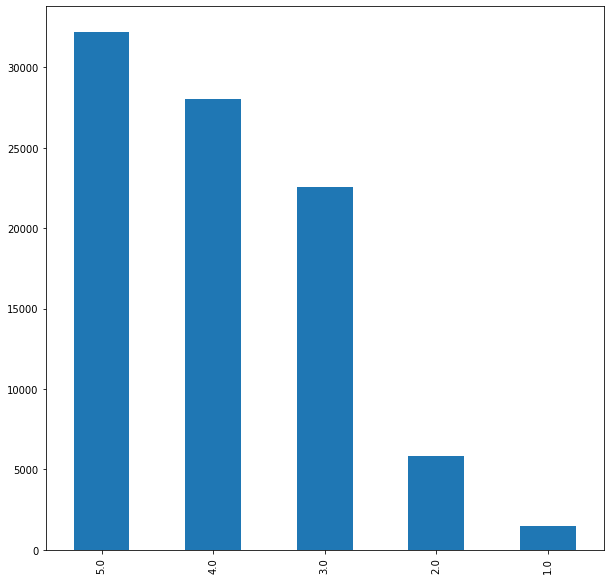

In [13]:
not_hospitalized = nhis_df.loc[nhis_df['phospyr'] == 'No', 'health_order']
not_hospitalized.value_counts().plot(kind='bar', figsize = (10,10));

(b) 入院経験ありのsample

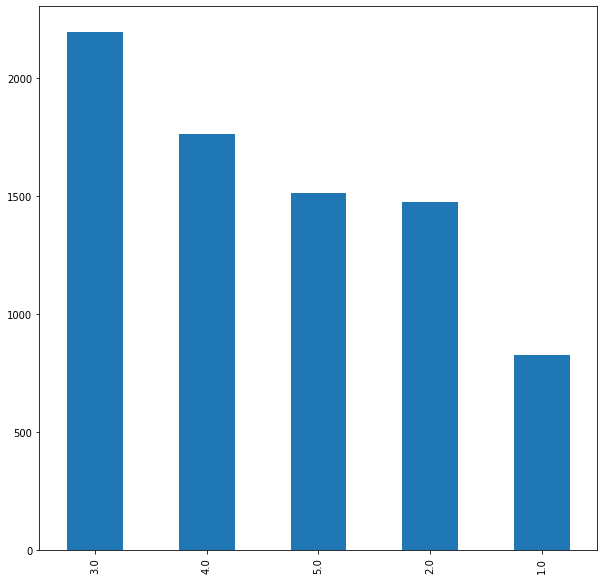

In [14]:
hospitalized = nhis_df.loc[nhis_df['phospyr'] == 'Yes', 'health_order']
hospitalized.value_counts().plot(kind='bar', figsize = (10,10));

上の (a), (b) の平均の差に対して有意差検定を実行。

In [15]:
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans


rct_ttest = CompareMeans(DescrStatsW(not_hospitalized), 
                         DescrStatsW(hospitalized))
rct_ttest.ttest_ind()  # defaults two-sided, pooled
rct_ttest.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,0.7149,0.012,58.912,0.000,0.691,0.739


単純な比較の結果、病院経験のあるサンプルは病院経験なしのサンプルに対して健康状態が悪いという結論が得られた。しかし、病院に行かないような人はもともと健康（vice versa）で、セレクションバイアスの一例とも考えらえる。病院にいくような人同士の間で、病院に行った場合と行かなかった場合の健康状態を比べるべき。

#### REMARK
selection biasの存在が疑わしい時は、（結果解釈の方向性が変わってしまう時は特に、）naiveな比較はよくない

### 様々な比較に入り込むバイアス
see [Calling Bullshit](https://callingbullshit.org)

## 1.3 potential outcome framework
$i$をindex, $D_i = \{0, 1\}$をtreatment variableとしたとき、

$$
\text{Potential outcome} = \begin{cases}
Y_{1i} & \text{if } D_i = 1\\
Y_{0i} & \text{if } D_i = 0
\end{cases}
$$

$Y_i$をobserved outcomeとすると
$$
Y_i = Y_{0i}(1 - D_i) + D_iY_{1i} 
$$
と表現される。

このとき、$Y_{1i}, Y_{0i}$はそれぞれtreatmentを受けたとき、受けなかったときの結果変数と考え、いずれか一方しか分析者は観測できないとする。

### 有意差検定の概要と限界
ここではt-testがなぜ多くの場面で使用されるかをメモする

#### 定義：t分布
確率変数Tがpdf
$$
f(t) = \frac{\Gamma\left(\frac{n+1}{2}\right)}{\sqrt{n\pi}\Gamma\left(\frac{n}{2}\right)}\left(1 + \frac{t^2}{n}\right)^{-\left(\frac{n+1}{2}\right)}
$$
を持つ時、Tは自由度nのt分布に従うという。

確率密度関数より$f(t) = f(-t)$、$t = 0$に対して左右対象であることがわかる。

#### 定理
確率変数$Z$と$X$が互いに独立で$Z\sim N(0, 1)$, $X\sim\chi^2(n)$ならば
$$
T = \frac{Z}{\sqrt{X/n}}\sim t(n)
$$
が成立する。

#### t分布の特徴
t 分布は$N(0, 1)$と比べ、裾があつい分布となっている。

#### t分布と正規分布の比較

In [16]:
from scipy.stats import norm
from scipy.stats import t

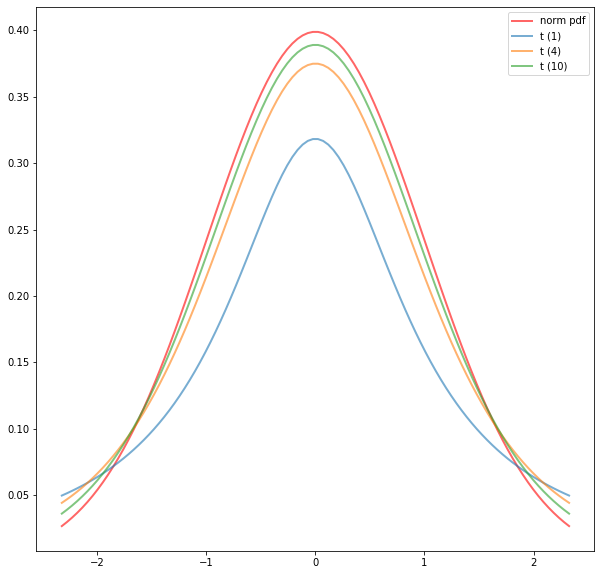

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
degree_freedom = (1, 4, 10)
ax.plot(x, norm.pdf(x),
        'r-', lw=2, alpha=0.6, label='norm pdf')

for i in degree_freedom:
    ax.plot(x, t.pdf(x, i),
         lw=2, alpha=0.6, label='t ({}) '.format(i))



plt.legend();

### CLT
sample momentsは漸近的に正規分布に従う、という定理。

$Y_1, ..., Y_n$はi.i.dで、$E[Y_i] = \mu, Var(Y_i) = \sigma^2<\infty$とする。ここで標本平均を$\bar Y$と表記すると

$$
Z = \frac{\bar Y - \mu}{\sigma/\sqrt{n}}
$$
は標準正規分布に分布収束する。つまり、
$$
\lim_{n\to\infty}Pr(Z\leq z) = \Phi(x)
$$

nが十分大きい時、$Y_i$がどのような分布にしたがっていようが、$\bar Y$の分布は正規分布によって近似できる。これが、t-testが多用される理由の一つ。


### 正規母集団の標本平均と標本分散の独立性

Helmert行列を用いて証明する。

$$
\begin{aligned}
H = \begin{bmatrix}
1/\sqrt{n} & 1/\sqrt{n} & \cdots & \cdots &   1/\sqrt{n} \\
- 1/\sqrt{2} &  1/\sqrt{2} & 0 & \cdots & 0 \\
\vdots & \vdots &\vdots &\vdots & 0\\
-1/\sqrt{(n-1)n} & -1/\sqrt{(n-1)n} & -1/\sqrt{(n-1)n} & \cdots &(n-1)/\sqrt{(n-1)n}
\end{bmatrix}
\end{aligned}
$$

これは直行行列で$\mathbf H'\mathbf H = \mathbf H \mathbf H' = I$。

次に、$Z_1, ..., Z_n, i.i.d \sim N(0,1)$の$\mathbf z = (z_1, ..., z_n)'$における同時密度関数は

$$
f_Z(\mathbf z) = \frac{1}{(2\pi)^{n/2}}\exp(- \mathbf z'\mathbf z/2)
$$

次に

$$
\mathbf Y = (Y_1, ..., Y_n)' = HZ
$$

なる変数変換を考える。このときのYの同時密度関数は

$$
f_Y(\mathbf y) = \frac{1}{(2\pi|H|)^{n/2}}\exp(- \mathbf (H^{-1}y)'\mathbf H^{-1}y/2) = \frac{1}{(2\pi)^{n/2}}\exp(- \mathbf y'\mathbf y/2)
$$

従って、$Y_1, ..., Y_ni.i.d \sim N(0,1)$がわかる。このとき、$\mathbf Y = (Y_1, ..., Y_n)' = HZ$より、

$$
\begin{aligned}
Y_1 & = n^{-1/2}\sum Z_i = \sqrt{n}\bar Z\\
\sum(Z_i - \bar Z) & = Z'Z - n \bar Z^2 = Y'Y - Y_1^2 = Y_2^2 + ... + Y_n^2
\end{aligned}
$$

よって標本平均と標本分散の独立性が示された。

### Pythonでの確認

In [18]:
from scipy.linalg import helmert
import seaborn as sns

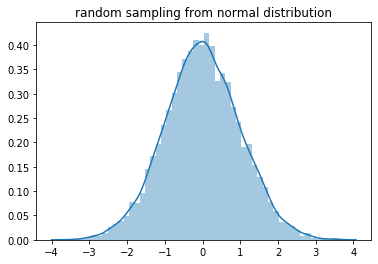

In [19]:
n = 10000
H = helmert(n, full = True)
Z = np.random.normal(loc = 0, scale = 1, size = n)

sns.distplot(Z).set_title('random sampling from normal distribution')
plt.show()

In [20]:
### 直行性の確認
I = np.identity(n)
I_hat = H.T @ H
np.allclose(I, I_hat)

True

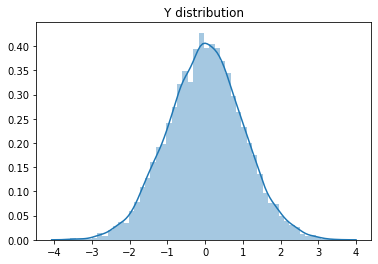

In [21]:
### 変数変換

Y = H @ Z
sns.distplot(Y).set_title('Y distribution')
plt.show()

In [22]:
### 正規分布との距離を計算
kstest(Y, 'norm')

KstestResult(statistic=0.009897069643690082, pvalue=0.2811971661608783)

In [23]:
### Zのsum of squareとY_2, ..., Y_nの確認
Y_sum = np.sum(Y[1:]**2)
Z_sum = np.sum(Y**2) - n*np.mean(Z)**2

np.allclose(Y_sum, Z_sum)

True

### CLTとt-分布の確認

CLTの確認

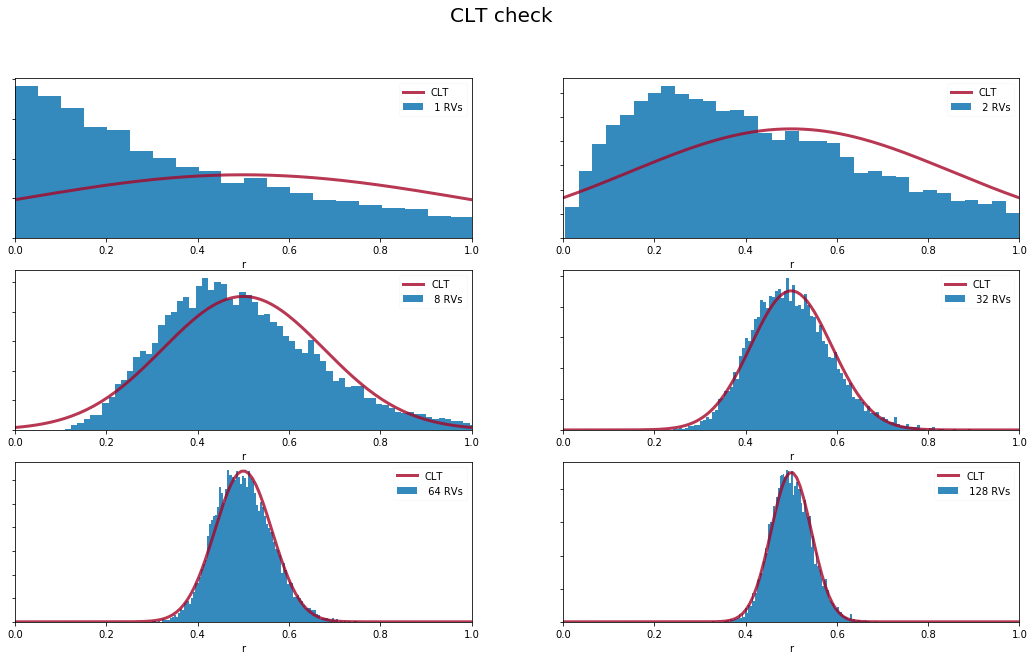

In [24]:
f = plt.figure(figsize=(18, 10))
 
def plotHist(nr, N, n_, mean, var0, x0):
    ''' plots the RVs'''
    x = np.zeros((N))
    sp = f.add_subplot(3, 2, n_ )
    
    for i in range(N):    
        for j in range(nr):
            x[i] += np.random.exponential(mean) 
        x[i] *= 1/nr
    plt.hist(x, 100, density=True, color='#348ABD', label=" %d RVs"%(nr));
    plt.setp(sp.get_yticklabels(), visible=False)
    
    variance = var0/nr                     
    fac = 1/np.sqrt(2*np.pi*variance)
    dist = fac*np.exp(-(x0-mean)**2/(2*variance))
    plt.plot(x0,dist,color='#A60628',linewidth=3,label='CLT',alpha=0.8)
    plt.xlabel('r')
    plt.xlim([0, 1])
    leg = plt.legend(loc="upper right")
    leg.get_frame().set_alpha(0.1)

    
N = 10000   # number of samples
nr = ([1, 2, 8, 32, 64, 128])

mean, var0 = 0.5, 0.5*0.5  # mean and variance of exponential distribution
x0 = np.linspace(0, 1, 128)

for i in range(np.size(nr)):
    plotHist(nr[i], N, i+1, mean, var0, x0)

plt.suptitle("CLT check",fontsize=20);

次にt分布の確認

ライブラリの読み込み

In [25]:
from scipy.stats import t
from scipy.stats import expon

plot

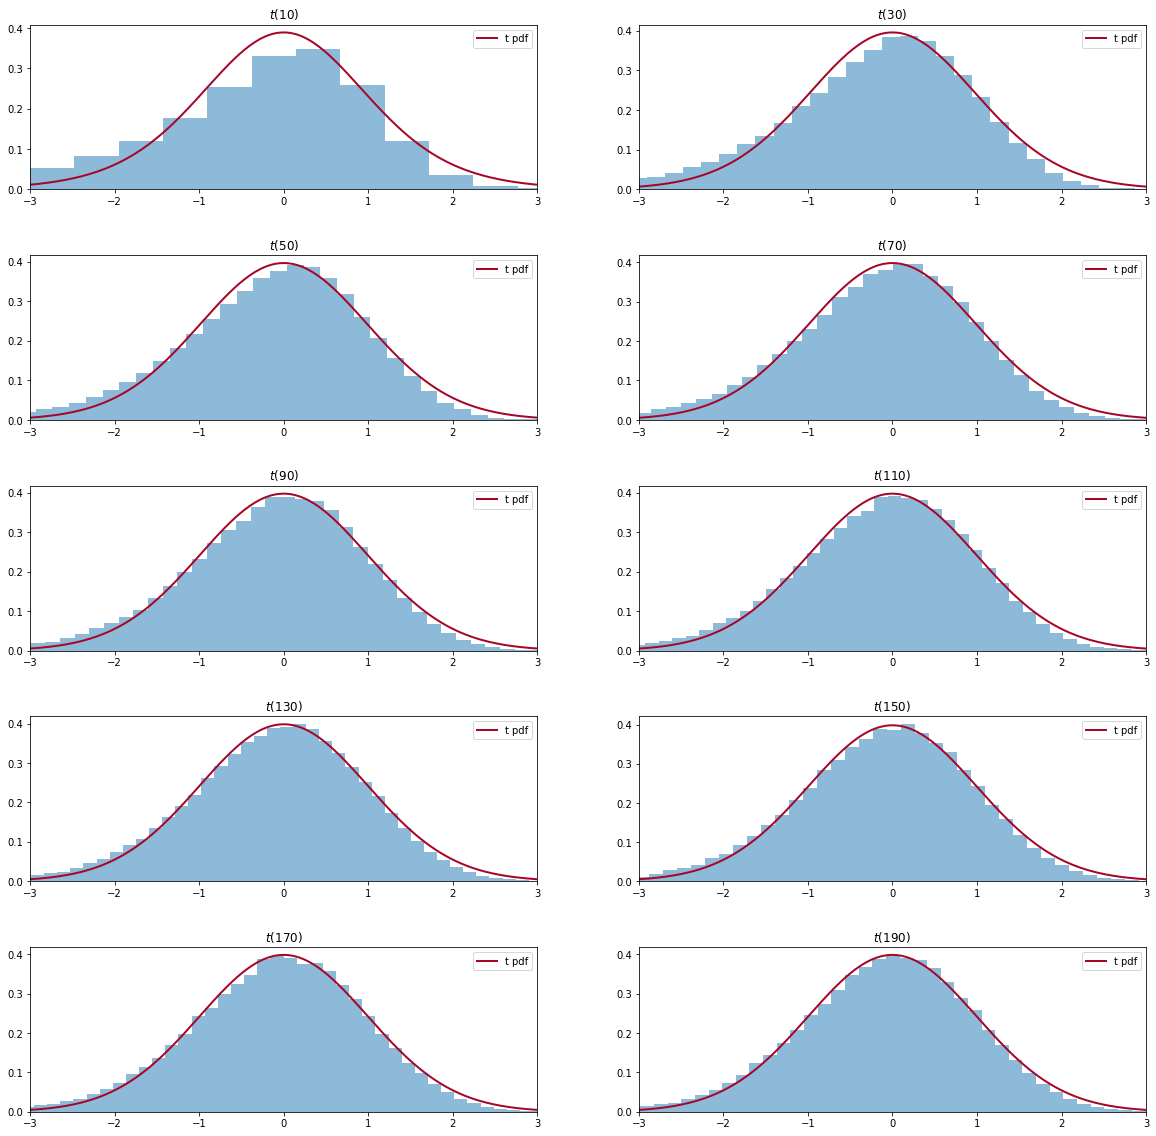

In [26]:
# Set parameters
ns = [i for i in range(10, 200, 20)]  # Choice of n
k = 100000                   # Number of draws of Y_n
distribution = expon(2)     # Exponential distribution, λ = 1/2
mu, s = distribution.mean(), distribution.std()

# plot parameters
fig, axes = plt.subplots(5, 2, figsize=(20, 20))
plt.subplots_adjust(hspace=0.4)
axes = axes.flatten()

for ax, n in zip(axes, ns):
    # Draw underlying RVs. Each row contains a draw of X_1,..,X_n
    data = distribution.rvs((k, n))
    # Compute mean, var of each row, producing k draws of \bar X_n
    sample_means = data.mean(axis=1)
    sample_vars = data.var(axis=1)

    statistics = (sample_means - mu)/np.sqrt(sample_vars/n)

    # Plot
    xmin, xmax = -3 * s, 3 * s
    ax.set_xlim(xmin, xmax)
    ax.hist(statistics, bins=60, alpha=0.5, density=True)
    xgrid = np.linspace(xmin, xmax, 200)
    ax.plot(xgrid, t.pdf(xgrid, n), 'k-', color='#A60628',lw=2, label = 't pdf')
    ax.set(title='$t ({})$'.format(n))
    ax.legend();



## 1.4 メールマーケティングの効果検証

### (1) clear variables

In [27]:
def clear_all():
    """Clears all the variables from the workspace of the application."""
    gl = globals().copy()
    for var in gl:
        if var[0] == '_': continue
        if 'func' in str(globals()[var]): continue
        if 'module' in str(globals()[var]): continue

clear_all()

### (2) パッケージのインストール

In [28]:
pass

### (3) ライブラリの読み込み

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
import scipy.optimize as optimize

### (4) dataの読み込み

In [30]:
df = pd.read_csv("http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  object 
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  object 
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  object 
 8   segment          64000 non-null  object 
 9   visit            64000 non-null  int64  
 10  conversion       64000 non-null  int64  
 11  spend            64000 non-null  float64
dtypes: float64(2), int64(6), object(4)
memory usage: 5.9+ MB


In [31]:
df.describe()

,recency,history,mens,womens,newbie,visit,conversion,spend
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781,0.009031,1.050908
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890,0.094604,15.036448
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000,499.000000


In [32]:
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


### (5) 前処理 

- missing valueのチェックを忘れずに

In [33]:
df.loc[:, 'treatment'] = df['segment'].map(lambda x: 1 if x == 'Mens E-Mail' else 0)
male_df = df.loc[df['segment'] != 'Womens E-Mail']
male_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42613 entries, 1 to 63999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          42613 non-null  int64  
 1   history_segment  42613 non-null  object 
 2   history          42613 non-null  float64
 3   mens             42613 non-null  int64  
 4   womens           42613 non-null  int64  
 5   zip_code         42613 non-null  object 
 6   newbie           42613 non-null  int64  
 7   channel          42613 non-null  object 
 8   segment          42613 non-null  object 
 9   visit            42613 non-null  int64  
 10  conversion       42613 non-null  int64  
 11  spend            42613 non-null  float64
 12  treatment        42613 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 4.6+ MB


In [34]:
male_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1
14,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0.0,0


### (6) 集計による比較

まずoutcome variableがどのように異なるか記述統計で出してみる

In [35]:
male_df.groupby('treatment').agg({'spend': 'mean', 'conversion': ['mean', 'count']})

spend conversion       
               mean       mean  count
treatment                            
0          0.652789   0.005726  21306
1          1.422617   0.012531  21307

box plotで確認してみる

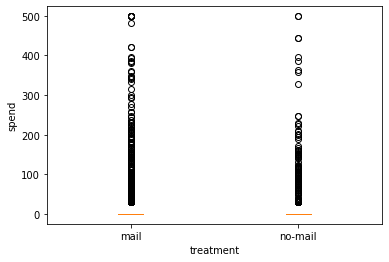

In [36]:
fig, ax = plt.subplots()
box_data = [male_df[male_df['treatment'] >= .5].loc[:, 'spend'], male_df[male_df['treatment'] < .5].loc[:, 'spend']]
ax.boxplot(box_data, labels=['mail', 'no-mail'])
ax.set_xlabel('treatment')
ax.set_ylabel('spend')
plt.show()

spend positiveにconditionした場合のbox plot(いわゆるAOVの可視化)

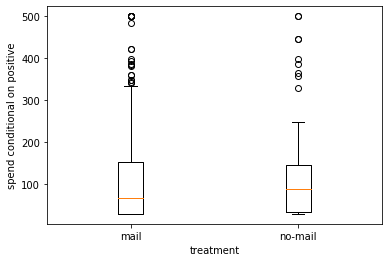

In [37]:
fig, ax = plt.subplots()
box_data = [male_df[(male_df['treatment'] >= .5) & (male_df['spend'] > 0)].loc[:, 'spend'], male_df[(male_df['treatment'] < .5) & (male_df['spend'] > 0)].loc[:, 'spend']]
ax.boxplot(box_data, labels=['mail', 'no-mail'])
ax.set_xlabel('treatment')
ax.set_ylabel('spend conditional on positive')
plt.show()

#### sampleのcovariateの分布

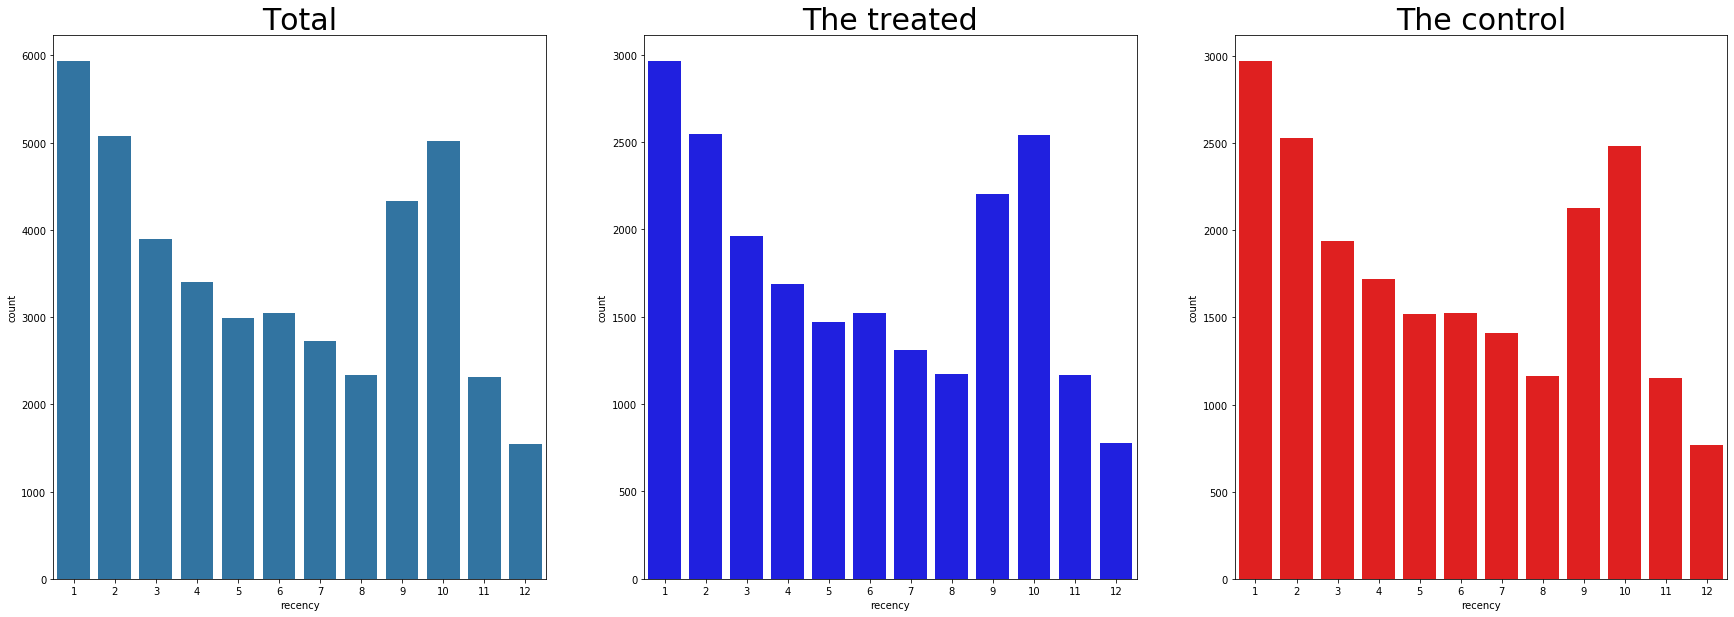

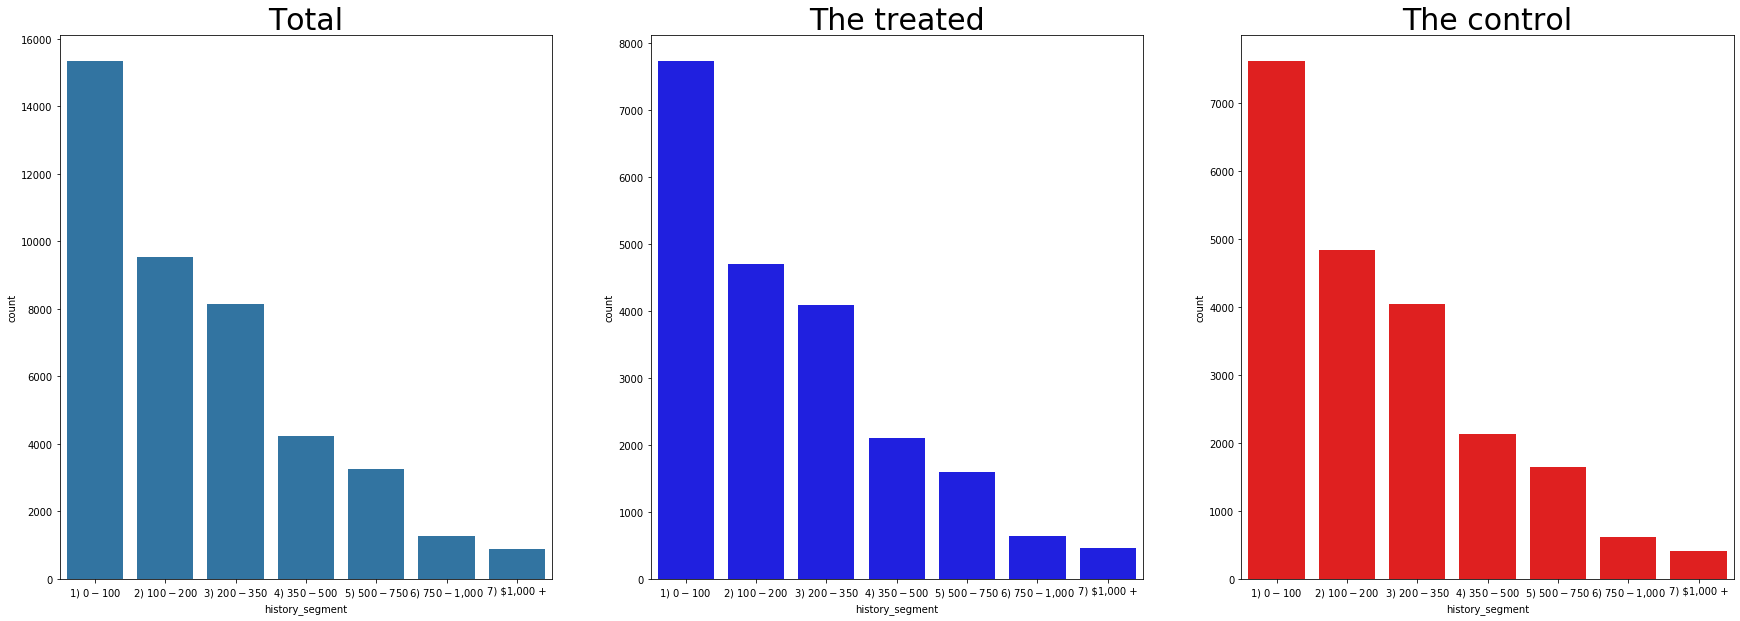

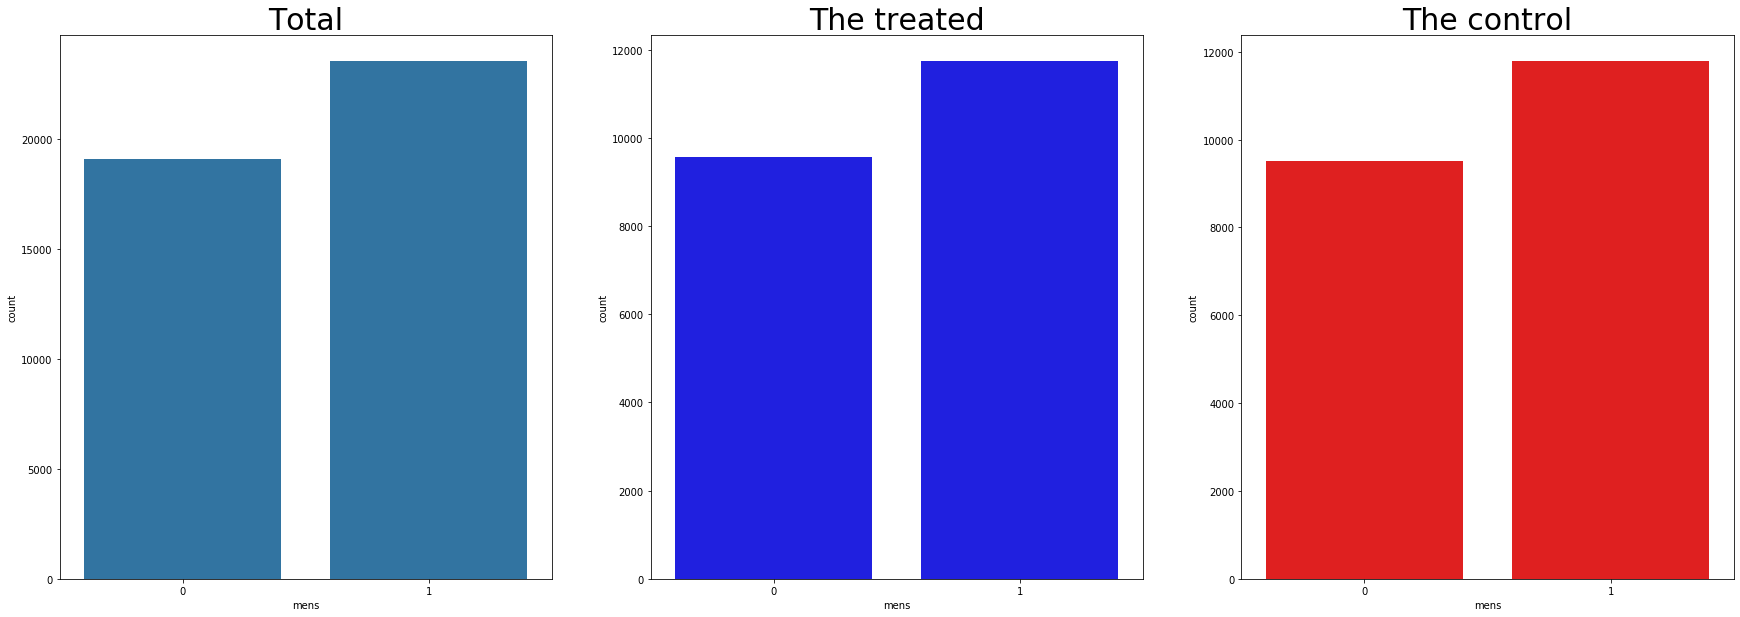

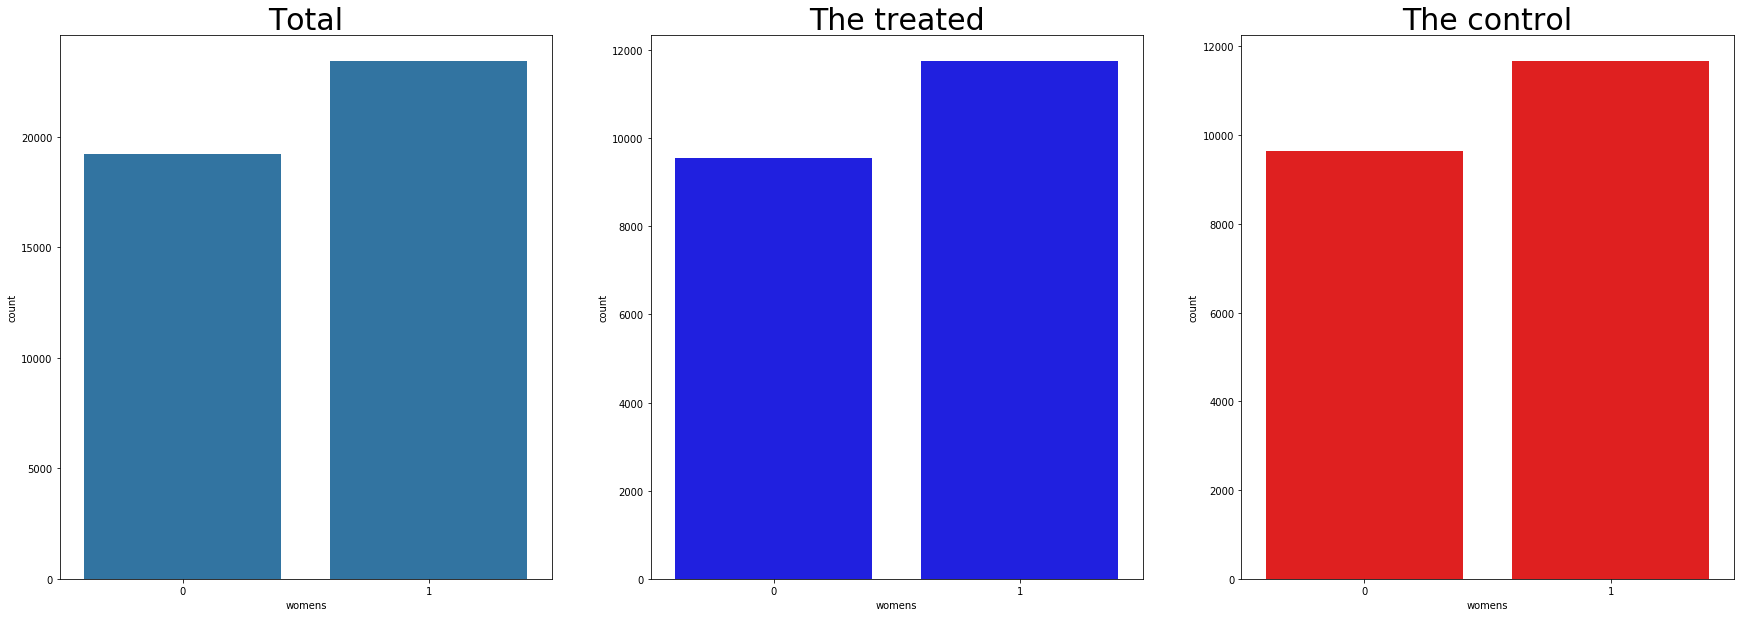

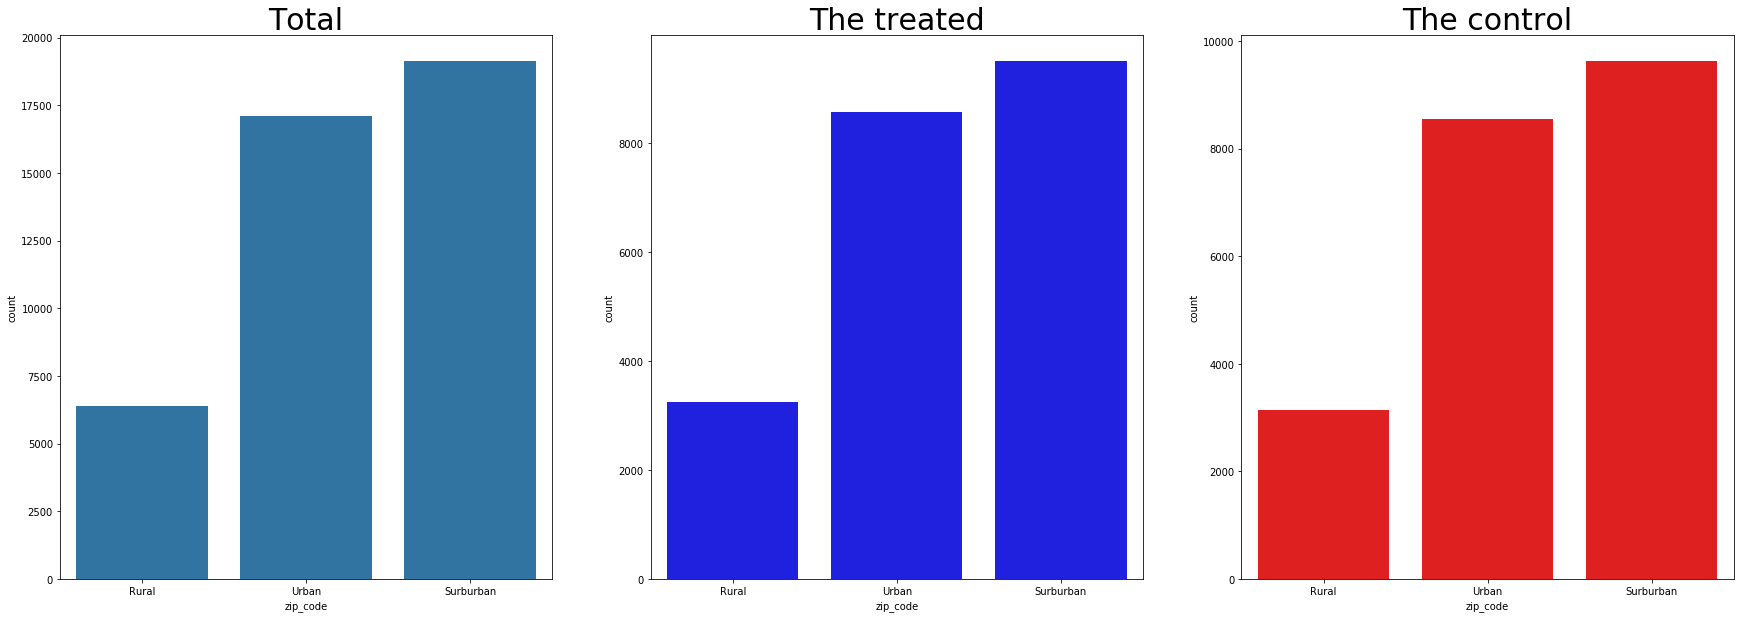

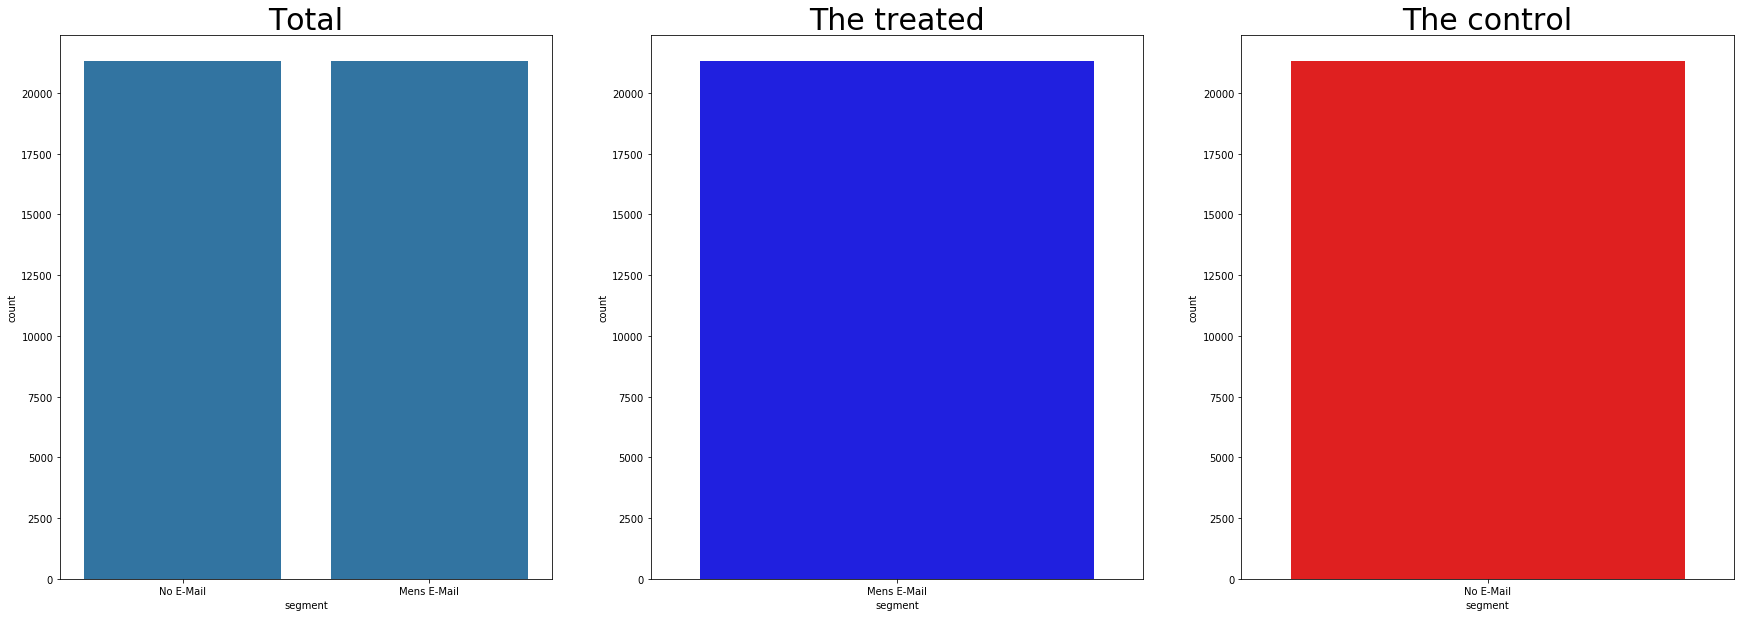

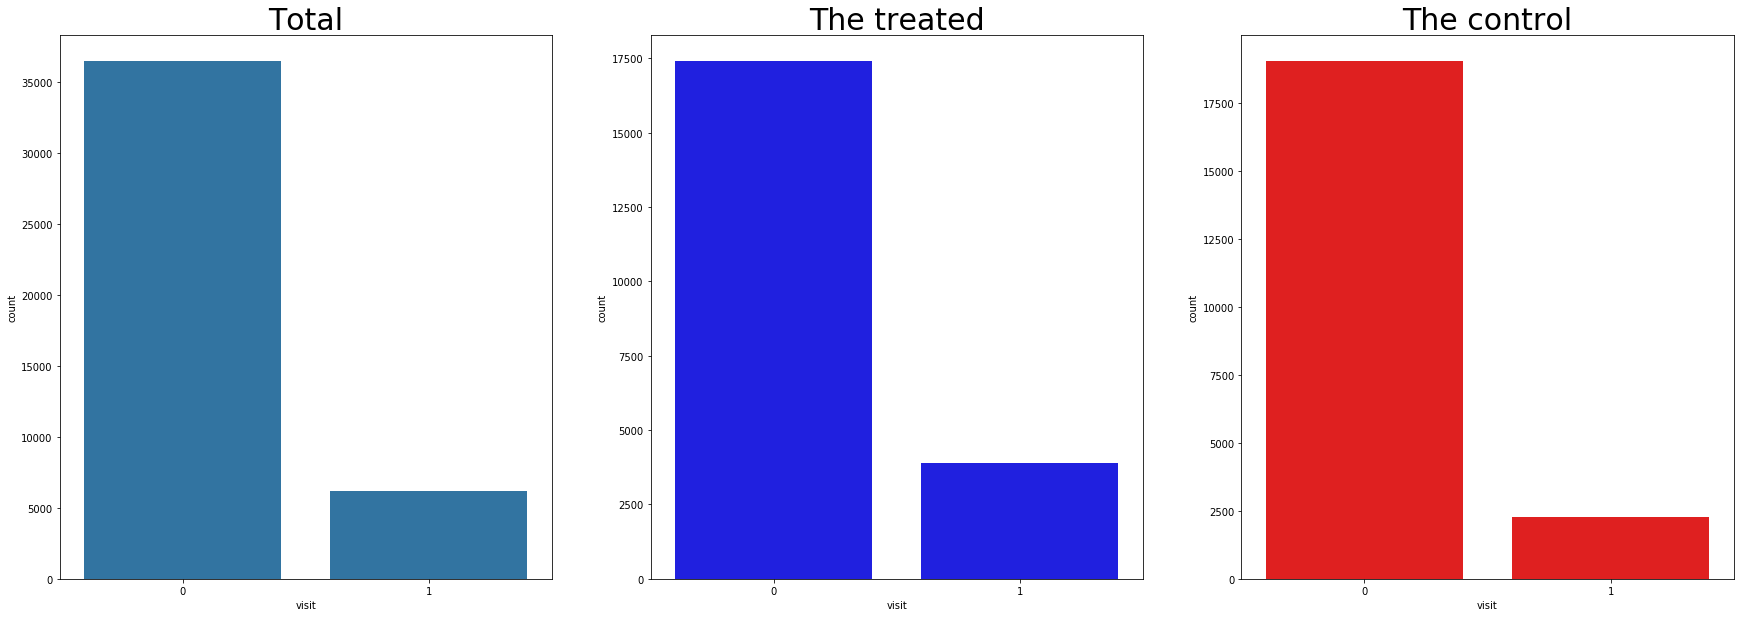

In [38]:
columns = ['recency', 'history_segment', 'mens', 'womens', 'zip_code', 'segment', 'visit']
for i, column in enumerate(columns):
    fig, axs = plt.subplots(1, 3, figsize=(30,10))
    if column == 'history_segment':
        order = sorted(list(set(male_df['history_segment'])))
    else:
        order = None
    sns.countplot(male_df[column], color="#1f77b4", ax = axs[0], order = order).set_title('Total',fontsize=30)
    sns.countplot(male_df[male_df['treatment'] >= .5][column], color="blue", ax = axs[1], order = order).set_title('The treated',fontsize=30)
    sns.countplot(male_df[male_df['treatment'] < .5][column], color="red", ax = axs[2], order = order).set_title('The control',fontsize=30)
    plt.show()

normalized

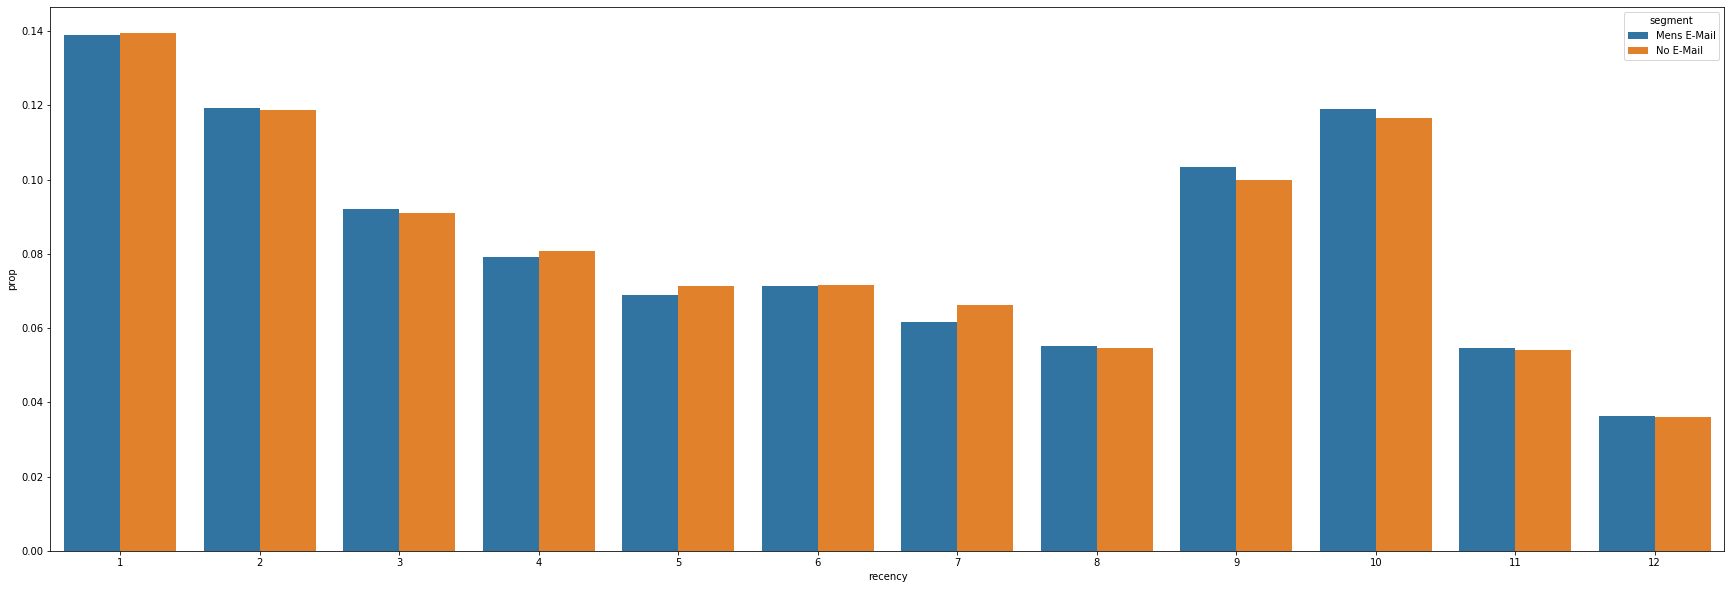

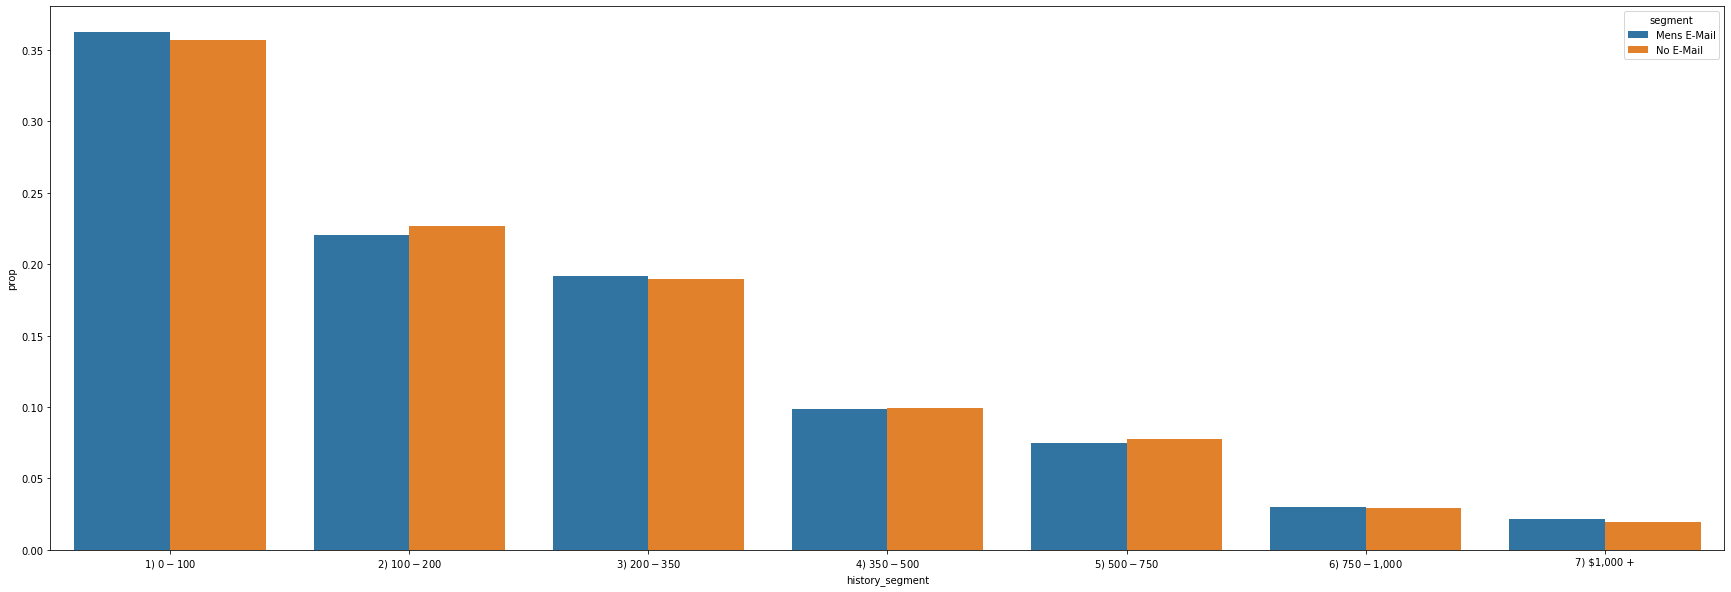

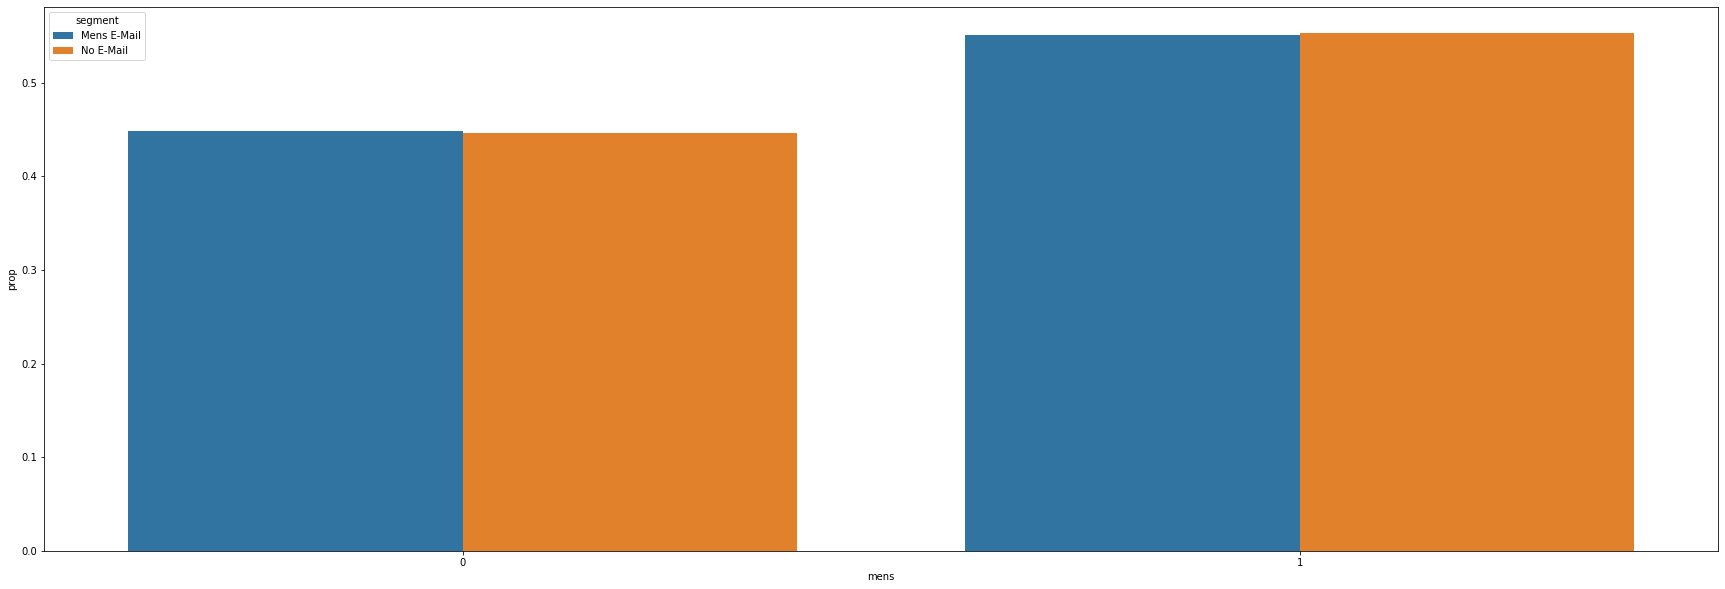

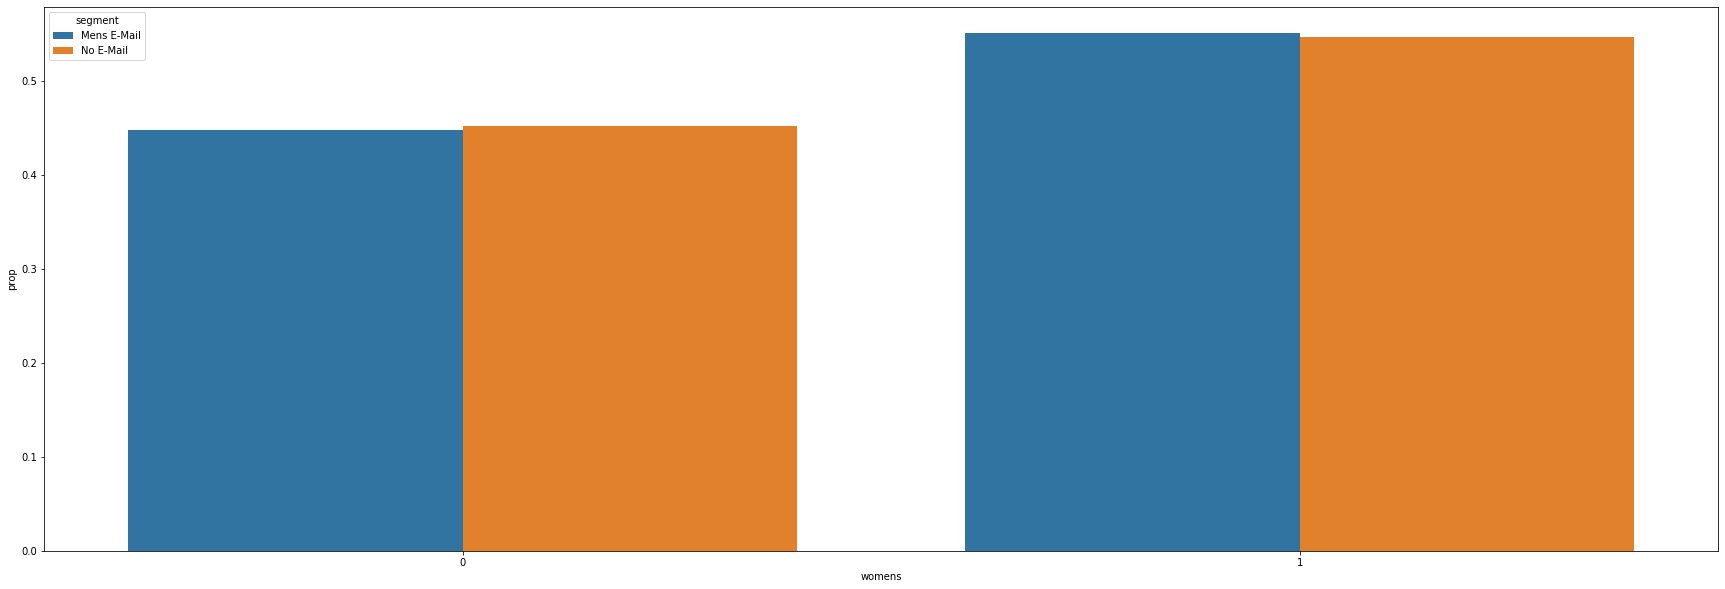

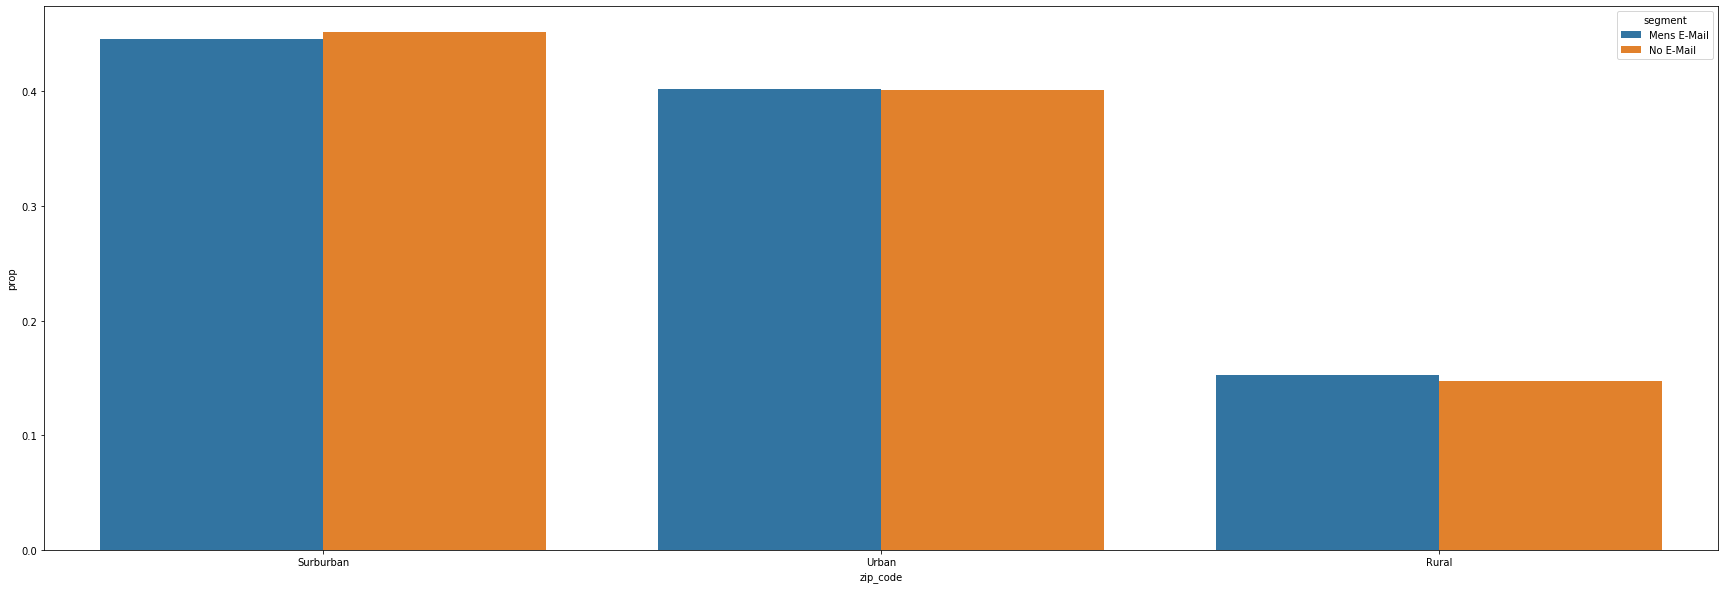

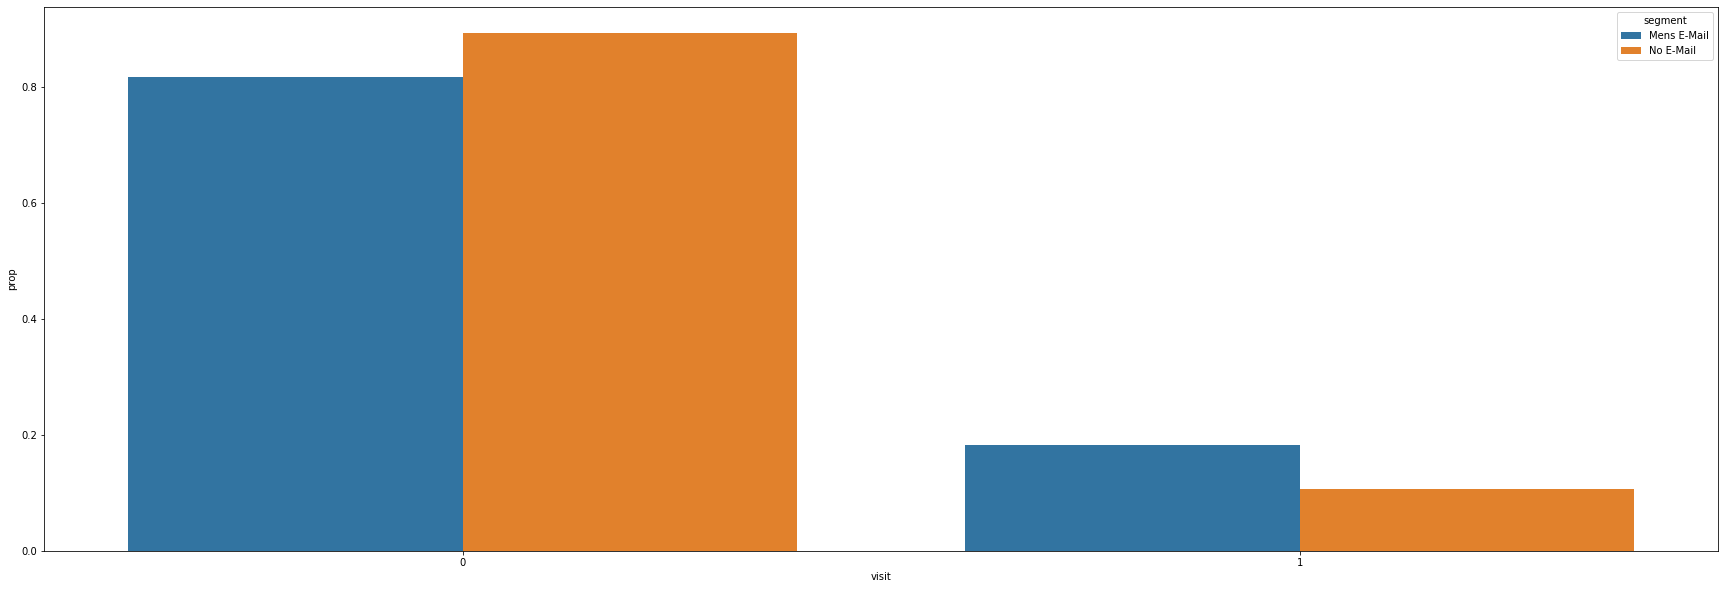

In [39]:
columns = ['recency', 'history_segment', 'mens', 'womens', 'zip_code', 'visit']
hue = 'segment'
y = 'prop'

for i, column in enumerate(columns):
    fig, axs = plt.subplots(1, 1, figsize=(30,10))
    if column == 'history_segment':
        order = sorted(list(set(male_df['history_segment'])))
    else:
        order = None
        
        
    
    prop_df = (male_df.groupby("segment")[column]
               .value_counts(normalize=True)
               .rename(y)
               .reset_index())
    
    sns.barplot(x=column, y=y, hue = hue, data=prop_df, ax=axs)

#### 連続変数の分布の確認

- history
- spend

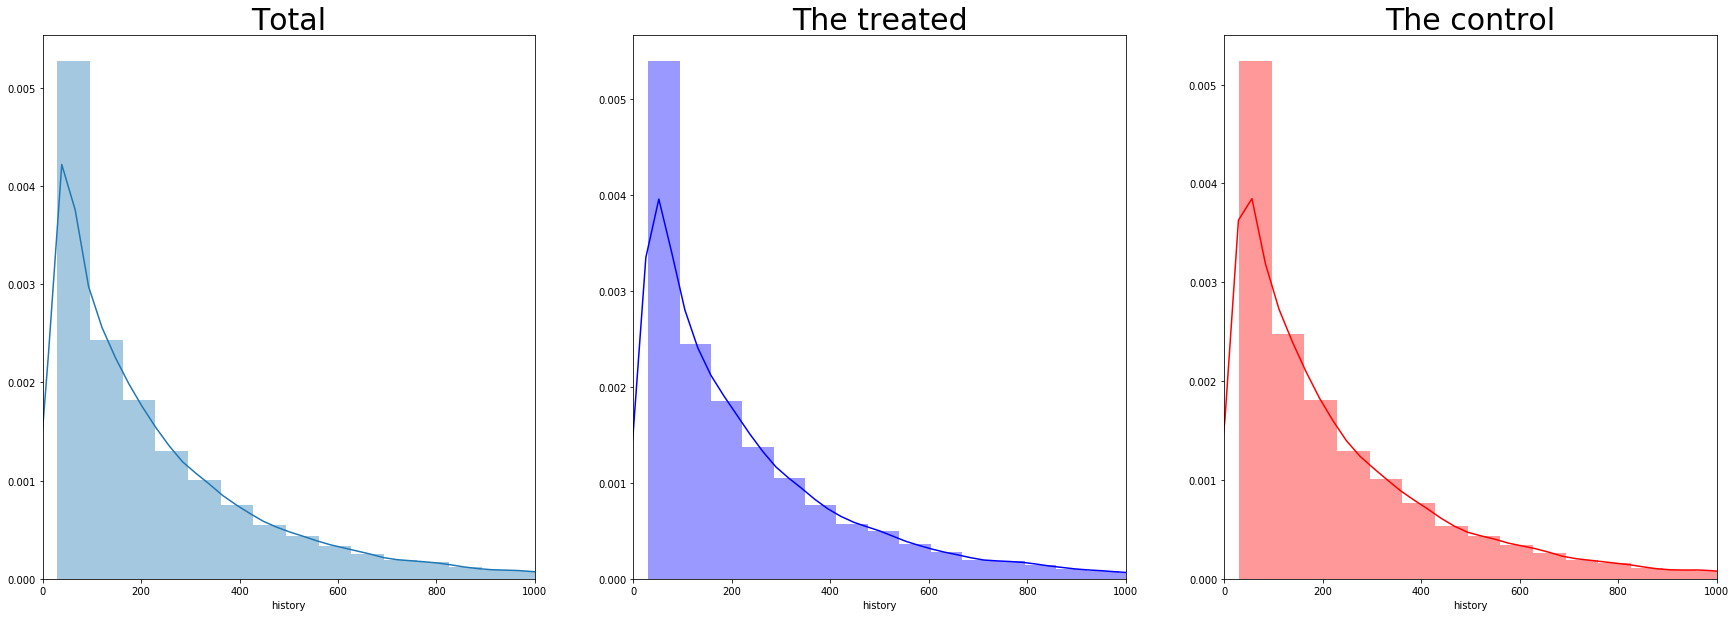

In [40]:
columns = ['history']
for i, column in enumerate(columns):
    fig, axs = plt.subplots(1, 3, figsize=(30,10))
    sns.distplot(male_df[column], color="#1f77b4", ax = axs[0]).set_title('Total',fontsize=30)
    sns.distplot(male_df[male_df['treatment'] >= .5][column], color="blue", ax = axs[1]).set_title('The treated',fontsize=30)
    sns.distplot(male_df[male_df['treatment'] < .5][column], color="red", ax = axs[2]).set_title('The control',fontsize=30)
    for j in range(0, 3):
        axs[j].set_xlim(0, 1000)
    plt.show()

### (6) t検定を行う
(a) 男性向けメールが配信されたグループの購買データを得る。

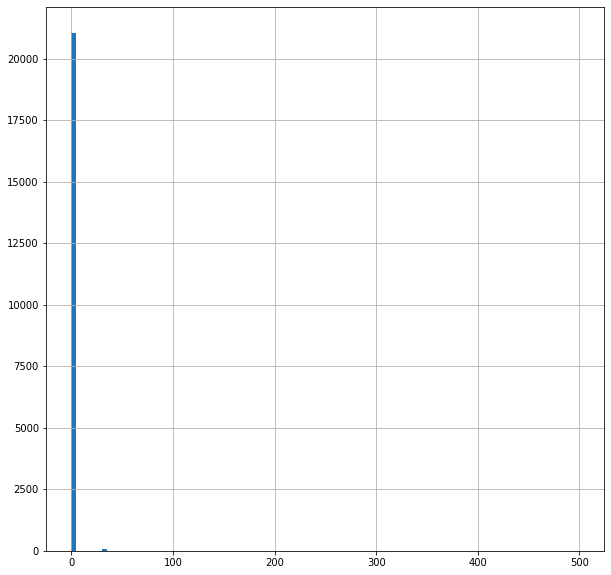

In [41]:
mens_mail = male_df.loc[male_df['treatment'] == 1, 'spend']
mens_mail.describe()
mens_mail.hist(bins =100, figsize = (10,10));

(b) メールが配信されなかったグループの購買データを得る。

count    21306.000000
mean         0.652789
std         11.588200
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        499.000000
Name: spend, dtype: float64

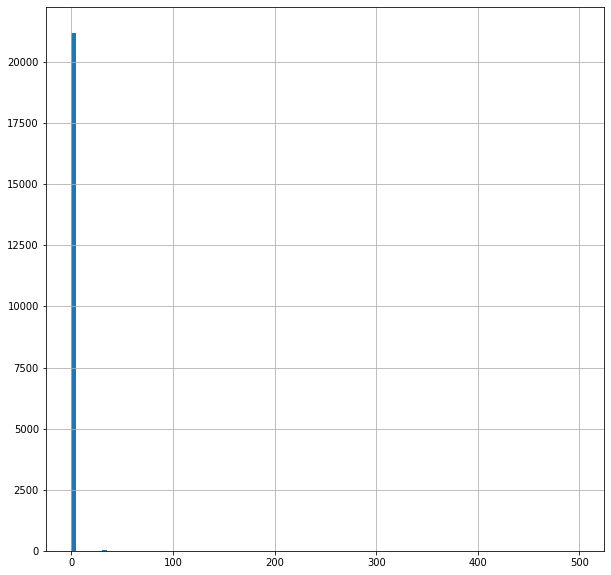

In [42]:
no_mail = male_df.loc[male_df['treatment'] == 0, 'spend']
no_mail.hist(bins=100, figsize = (10,10))
no_mail.describe()

上の (a), (b) の平均の差に対して有意差検定を実行。

In [43]:
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans


rct_ttest = CompareMeans(DescrStatsW(mens_mail), DescrStatsW(no_mail))
rct_ttest.ttest_ind()  # defaults two-sided, pooled
rct_ttest.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,0.7698,0.145,5.300,0.000,0.485,1.055


### conversionでrobustness check

count    21307.000000
mean         0.012531
std          0.111241
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: conversion, dtype: float64

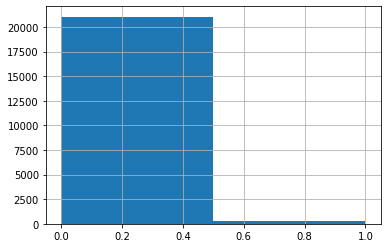

In [44]:
mens_mail_cv = male_df.loc[male_df['treatment'] == 1, 'conversion']
mens_mail_cv.hist(bins =2)
mens_mail_cv.describe()

count    21306.000000
mean         0.005726
std          0.075456
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: conversion, dtype: float64

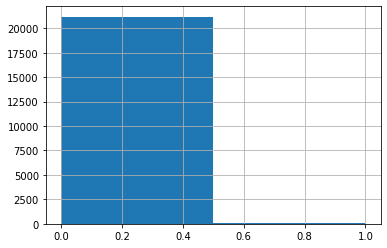

In [45]:
no_mail_cv = male_df.loc[male_df['treatment'] == 0, 'conversion']
no_mail_cv.hist(bins =2)
no_mail_cv.describe()

In [46]:
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans


rct_ttest_cv = CompareMeans(DescrStatsW(mens_mail_cv), DescrStatsW(no_mail_cv))
rct_ttest_cv.ttest_ind()  # defaults two-sided, pooled
rct_ttest_cv.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,0.0068,0.001,7.390,0.000,0.005,0.009


## 1.5 バイアスのあるデータによる効果の検証

セレクションバイアスのあるデータの作成

In [47]:
def bias(s):
  loyal = s['history'] > 300 or s['recency'] < 3 or s['channel'] == 'Multichannel'
  if (s['treatment'] == 1 and not loyal) or (s['treatment'] == 0 and loyal):
    return 0.5
  else:
    return 1.0

biased_data = male_df.sample(frac=0.5, weights=male_df.apply(bias, axis=1), random_state=42)
biased_data.info()
biased_data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21306 entries, 24106 to 56013
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          21306 non-null  int64  
 1   history_segment  21306 non-null  object 
 2   history          21306 non-null  float64
 3   mens             21306 non-null  int64  
 4   womens           21306 non-null  int64  
 5   zip_code         21306 non-null  object 
 6   newbie           21306 non-null  int64  
 7   channel          21306 non-null  object 
 8   segment          21306 non-null  object 
 9   visit            21306 non-null  int64  
 10  conversion       21306 non-null  int64  
 11  spend            21306 non-null  float64
 12  treatment        21306 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 2.3+ MB


,recency,history,mens,womens,newbie,visit,conversion,spend,treatment
count,21306.000000,21306.000000,21306.000000,21306.000000,21306.000000,21306.000000,21306.000000,21306.000000,21306.000000
mean,5.783958,241.820497,0.550690,0.549188,0.502347,0.145593,0.009152,1.098233,0.483291
std,3.518513,258.443012,0.497436,0.497586,0.500006,0.352706,0.095231,15.986469,0.499732
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,156.125000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,324.927500,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,12.000000,3215.970000,1.000000,1.000000,1.000000,1.000000,1.000000,499.000000,1.000000


Covariateの比較

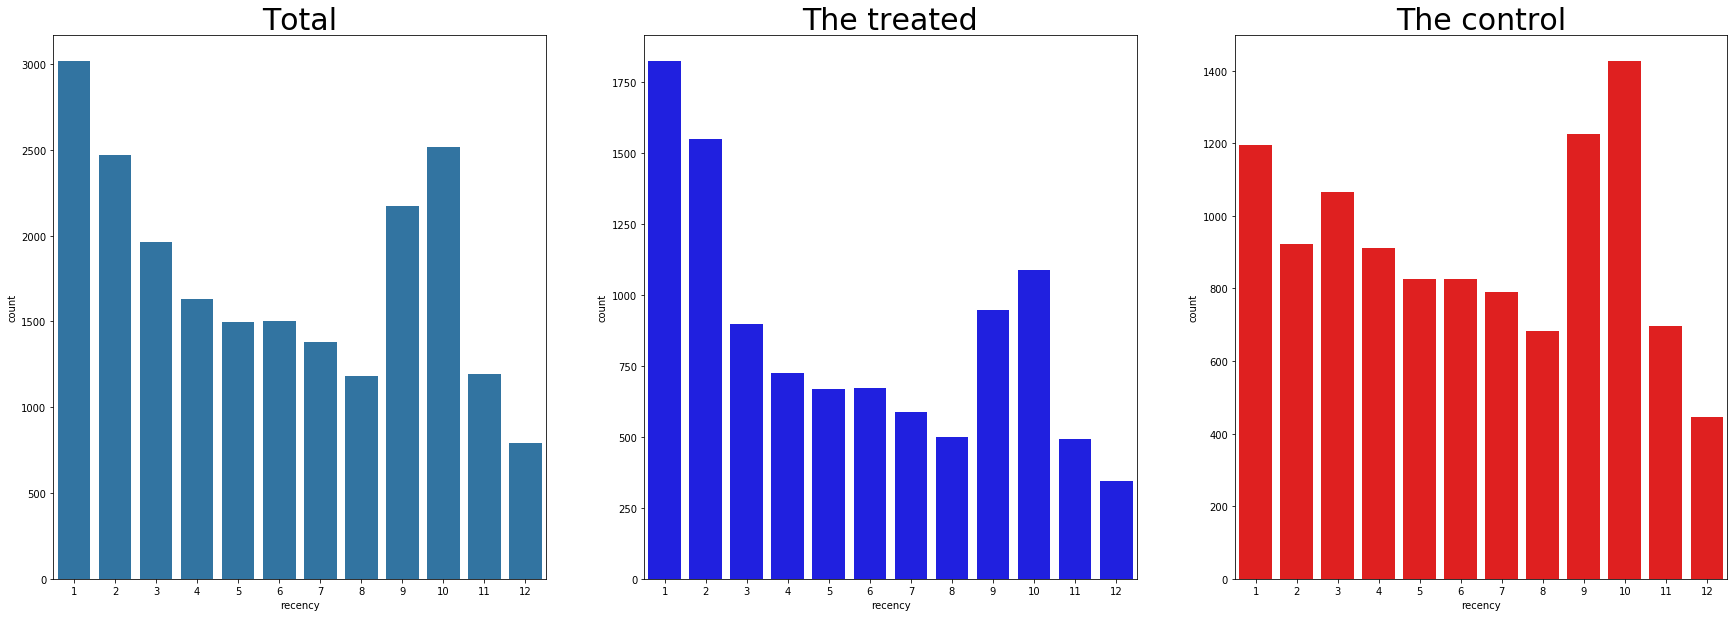

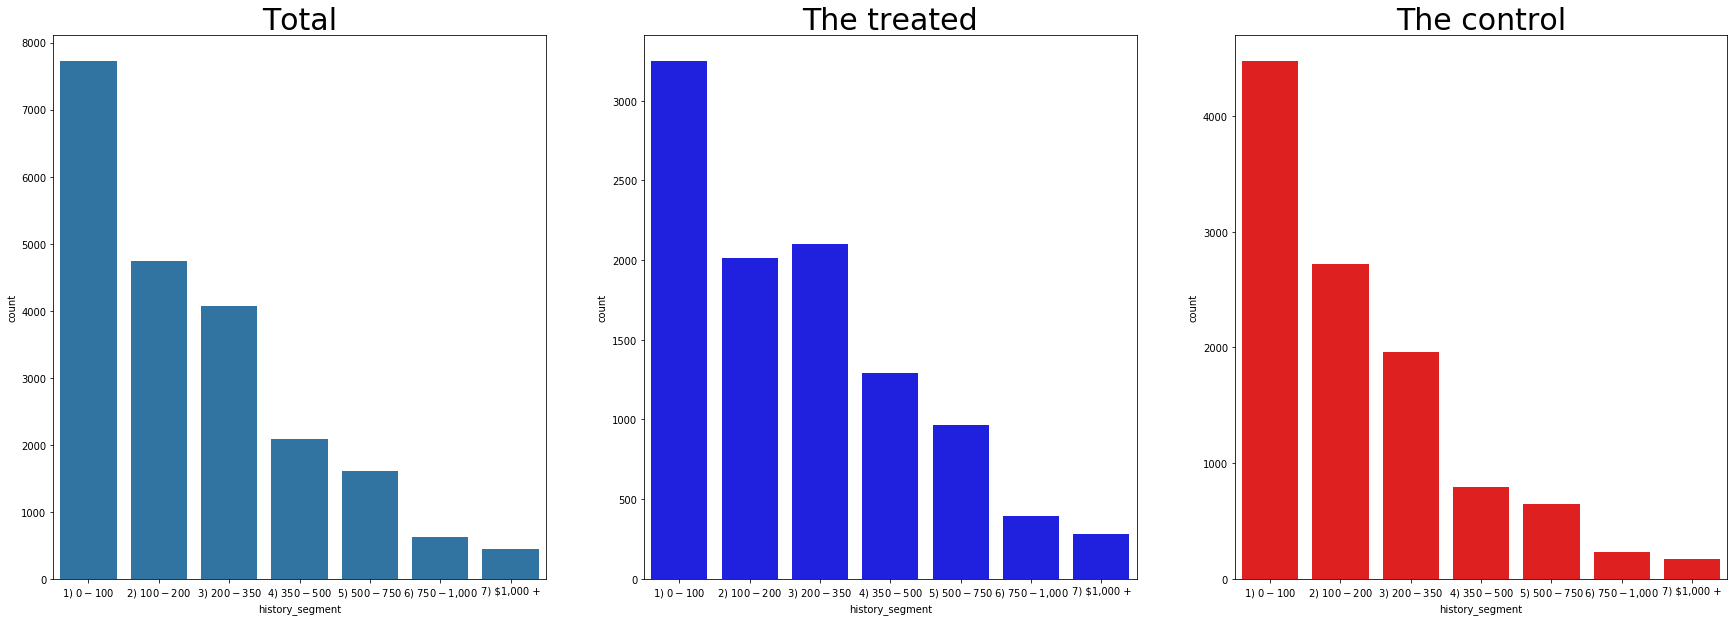

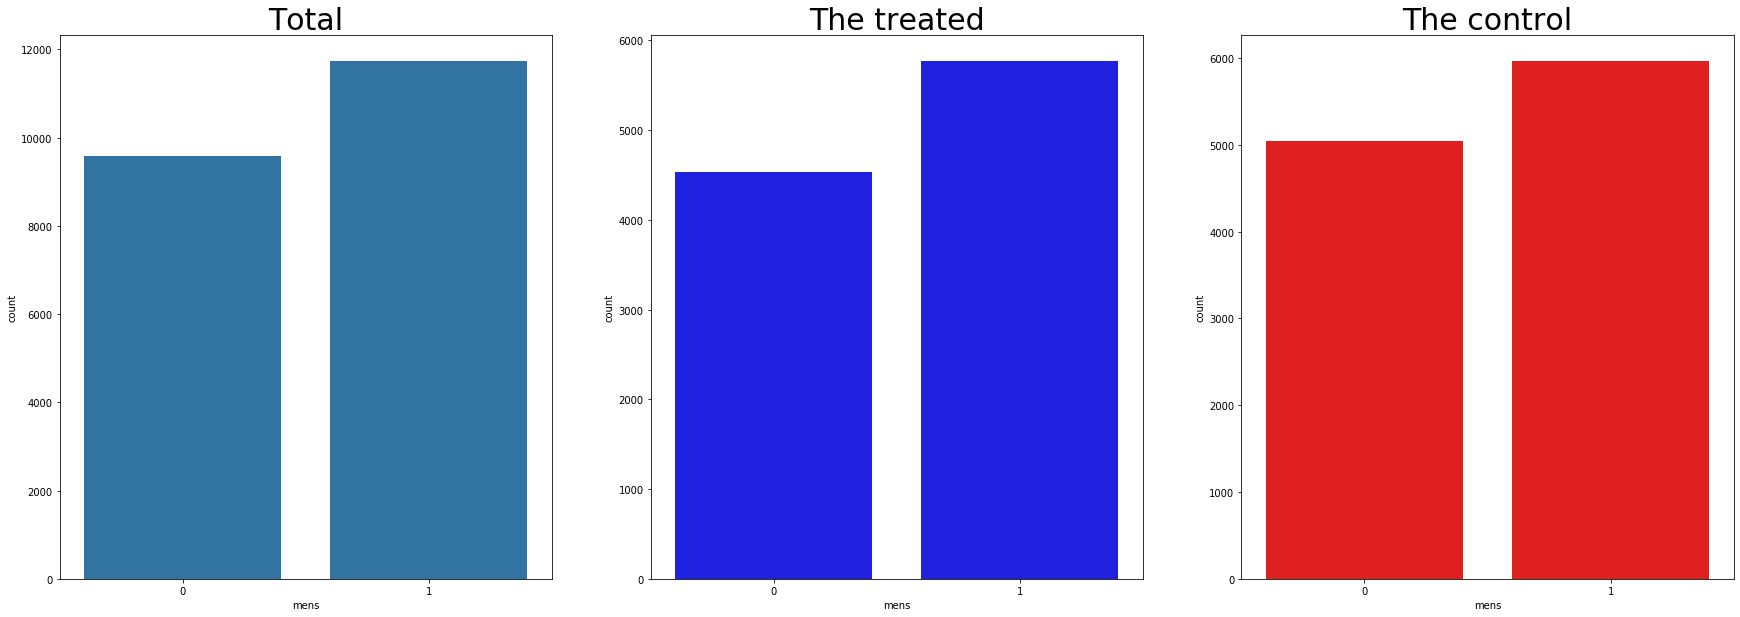

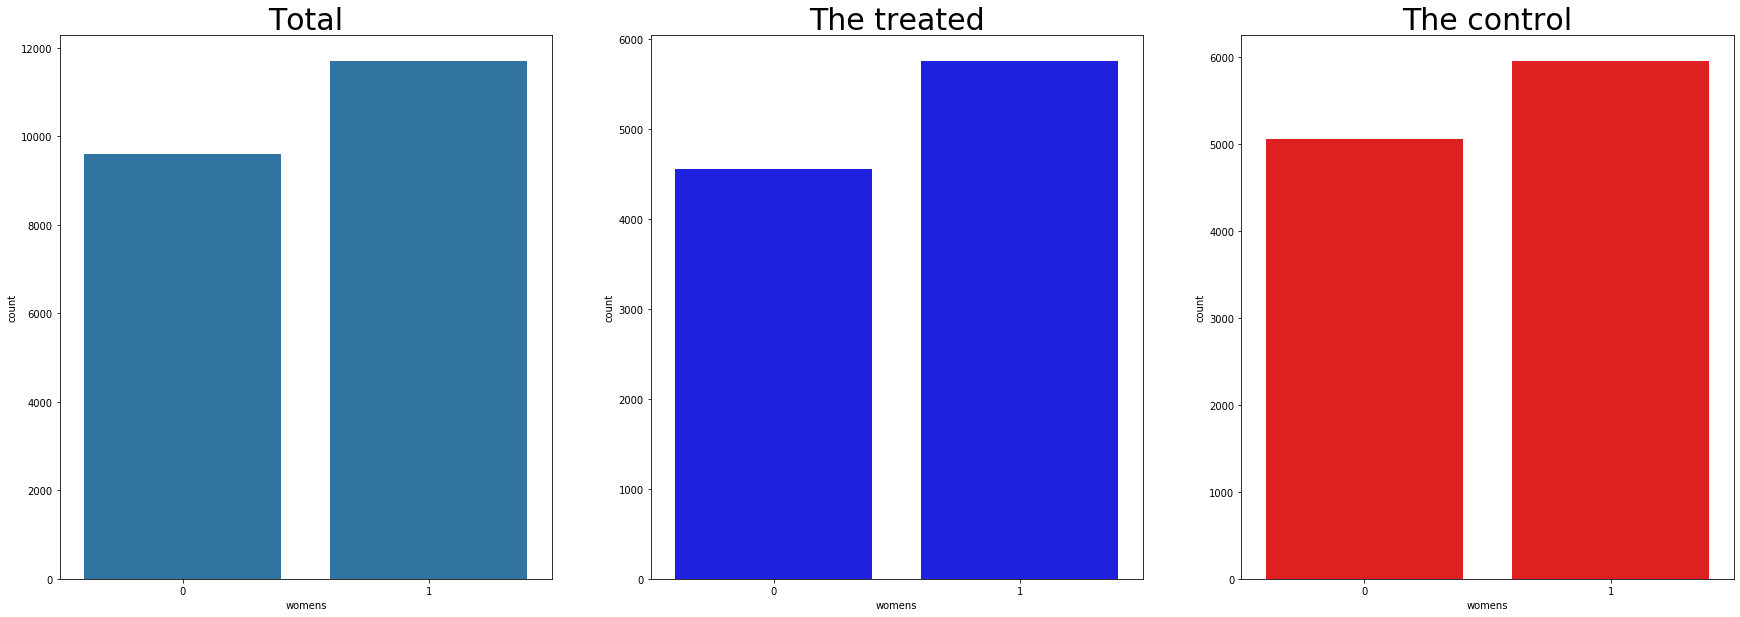

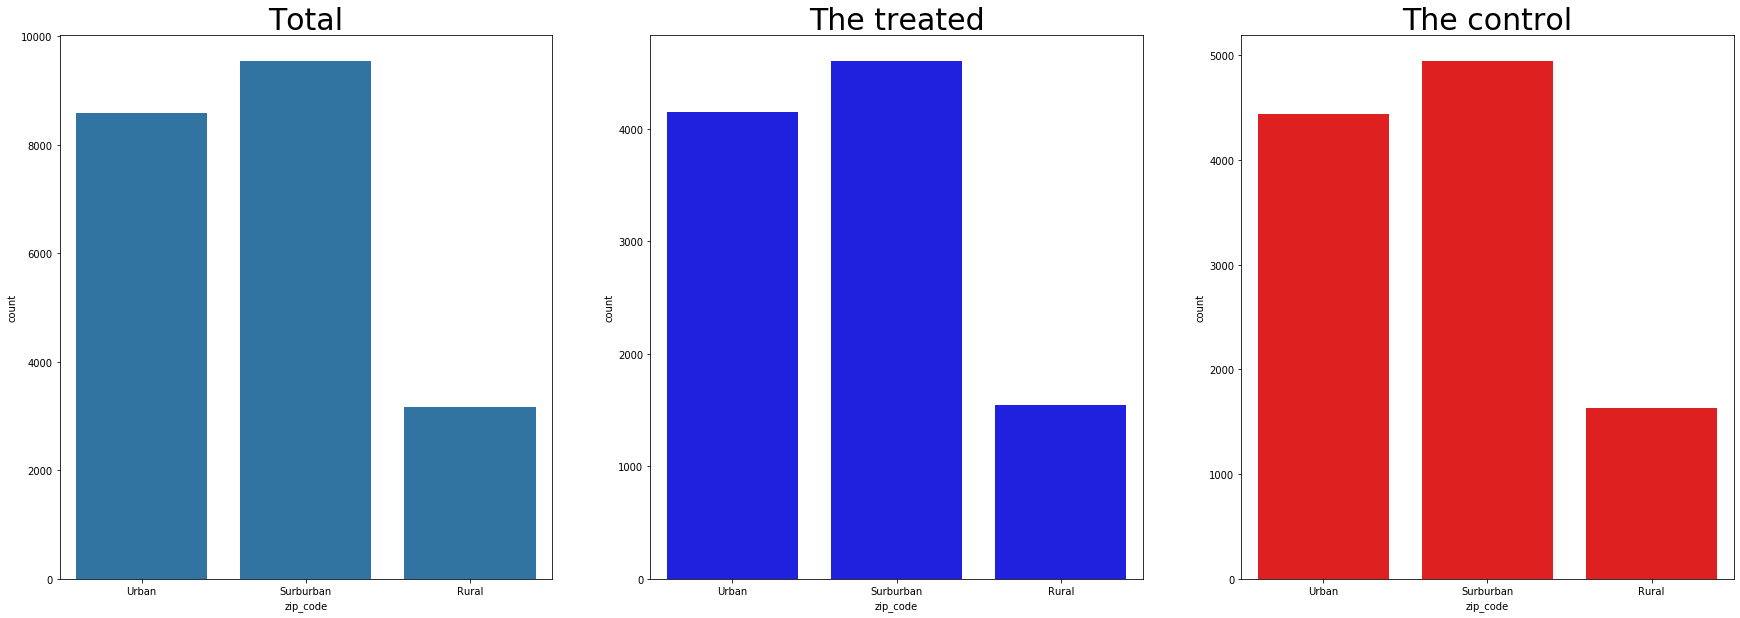

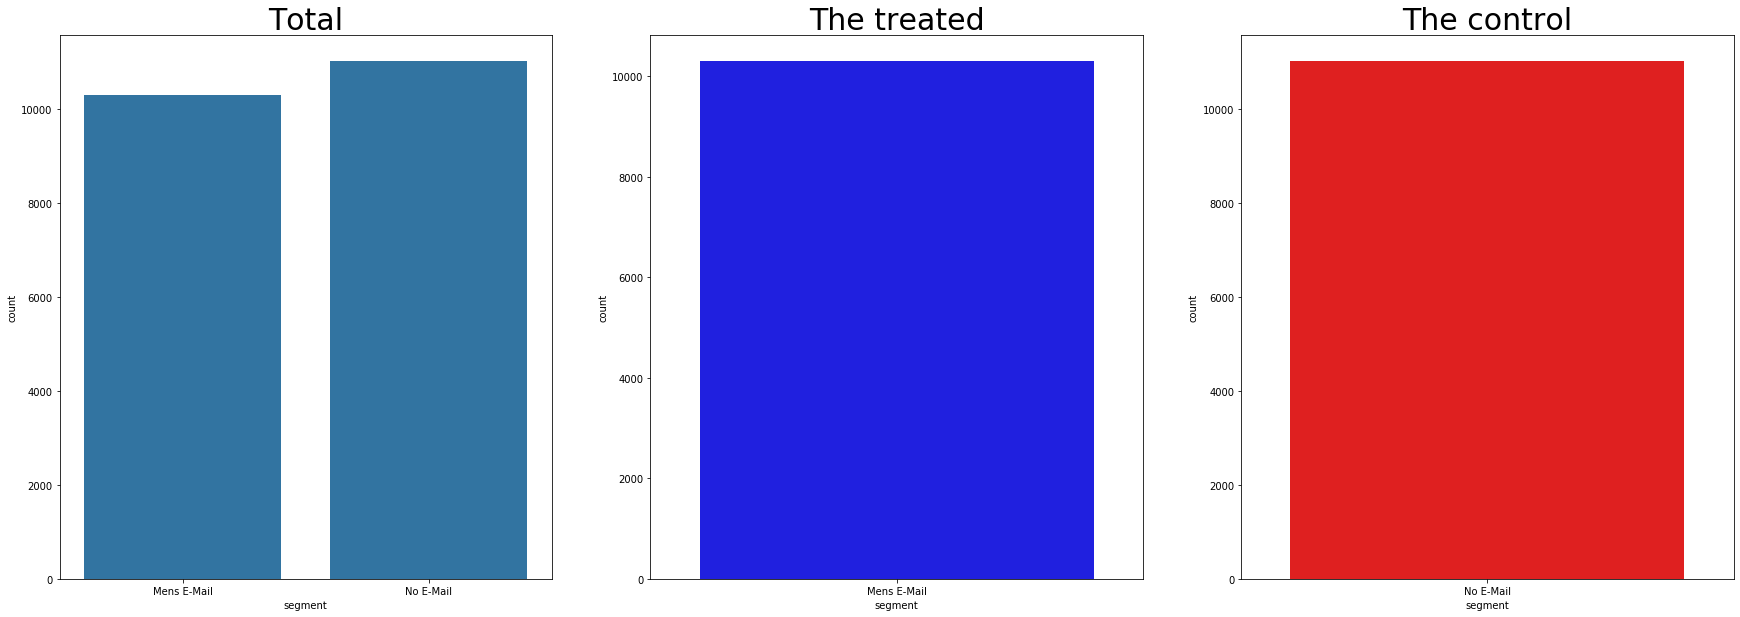

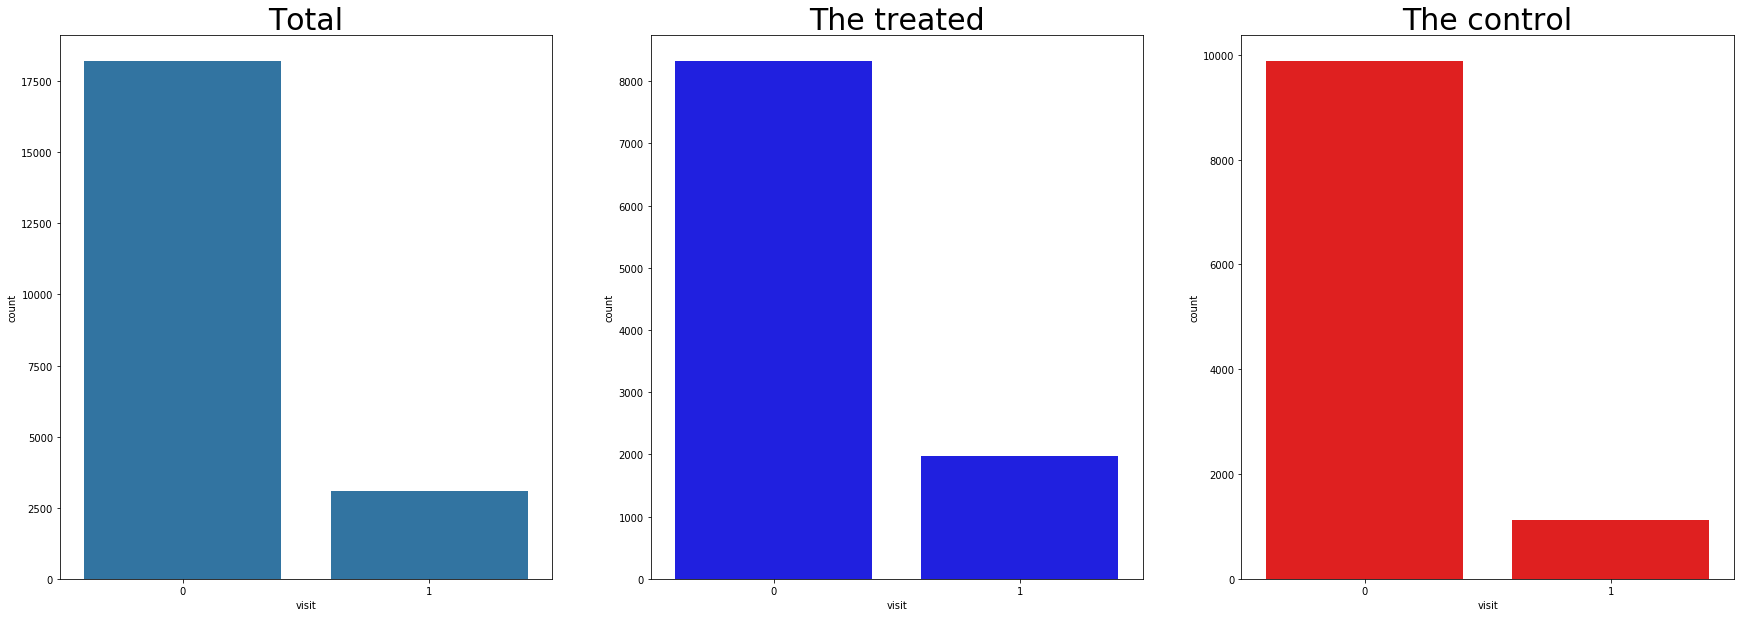

In [48]:
columns = ['recency', 'history_segment', 'mens', 'womens', 'zip_code', 'segment', 'visit']
for i, column in enumerate(columns):
    fig, axs = plt.subplots(1, 3, figsize=(30,10))
    if column == 'history_segment':
        order = sorted(list(set(biased_data['history_segment'])))
    else:
        order = None
    sns.countplot(biased_data[column], color="#1f77b4", ax = axs[0], order = order).set_title('Total',fontsize=30)
    sns.countplot(biased_data[biased_data['treatment'] >= .5][column], color="blue", ax = axs[1], order = order).set_title('The treated',fontsize=30)
    sns.countplot(biased_data[biased_data['treatment'] < .5][column], color="red", ax = axs[2], order = order).set_title('The control',fontsize=30)
    plt.show()

normalized

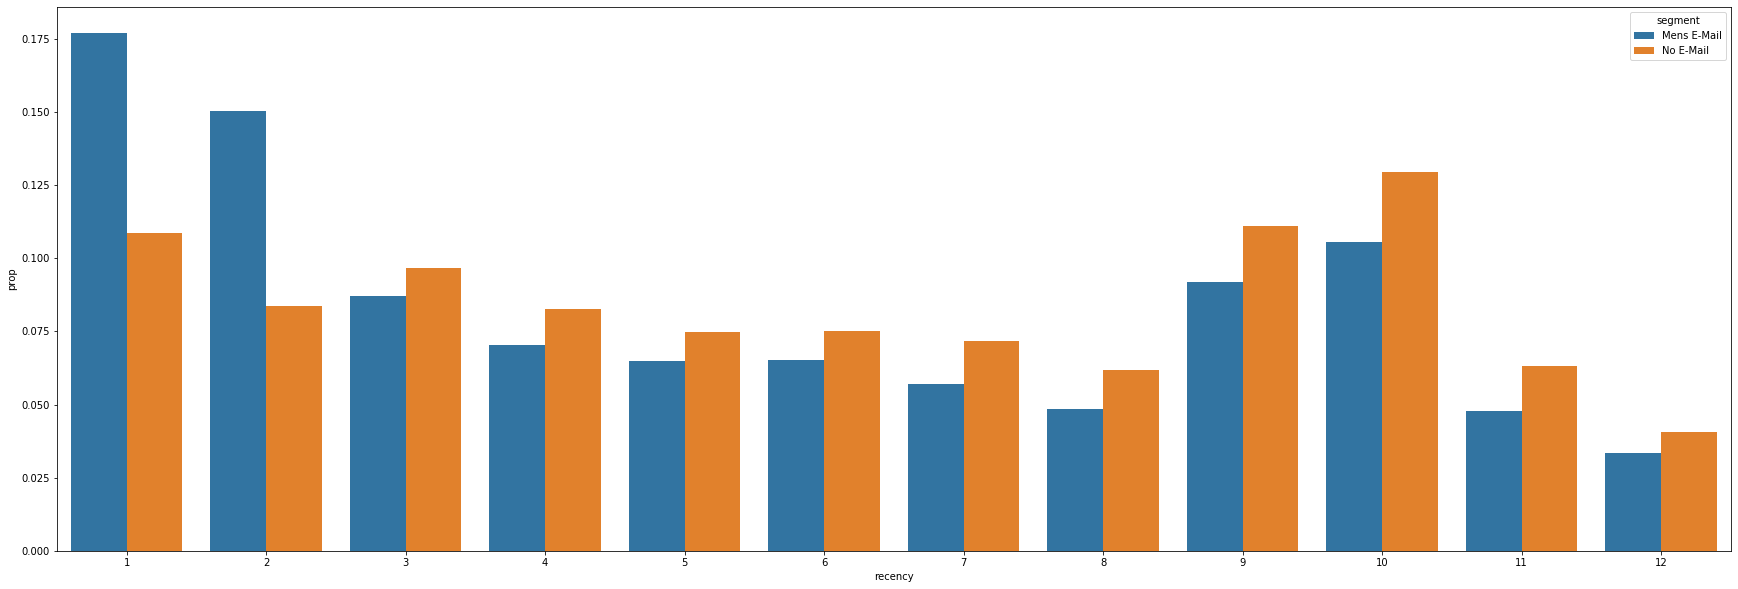

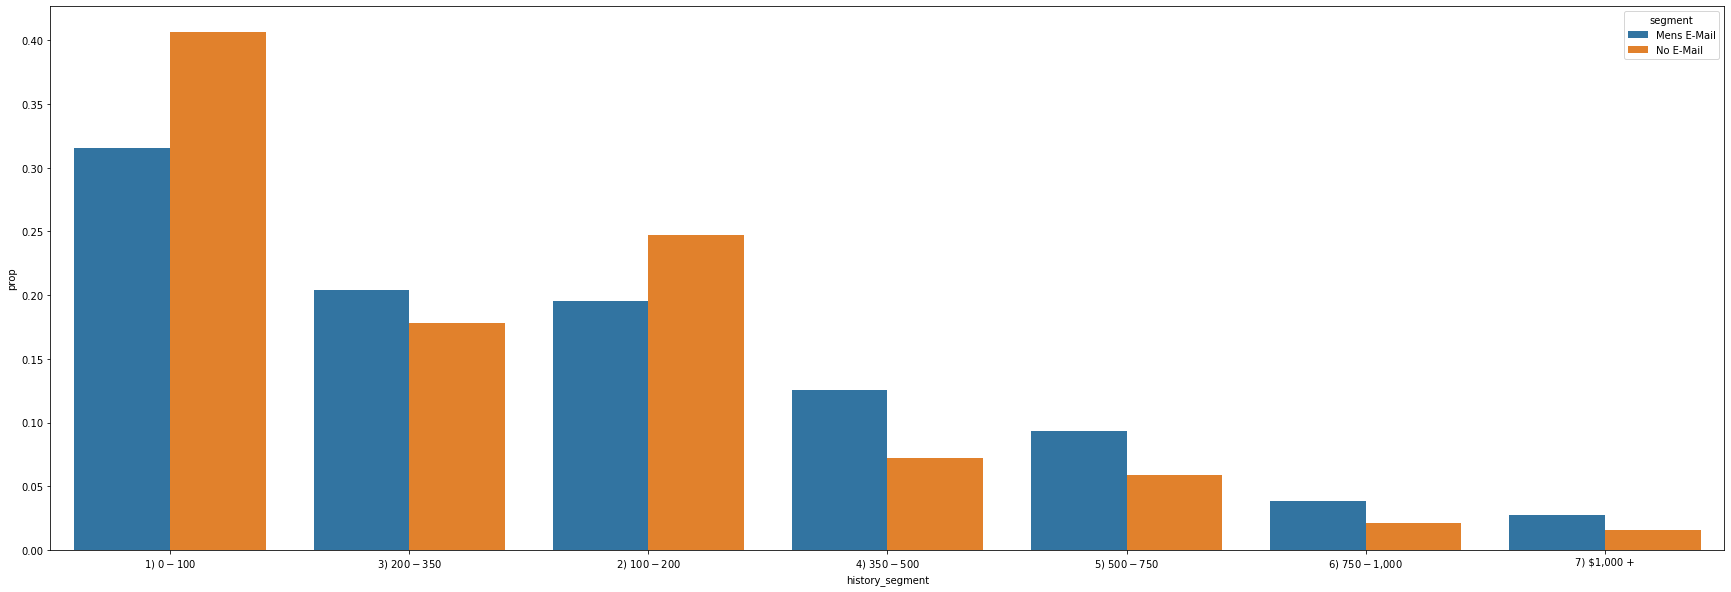

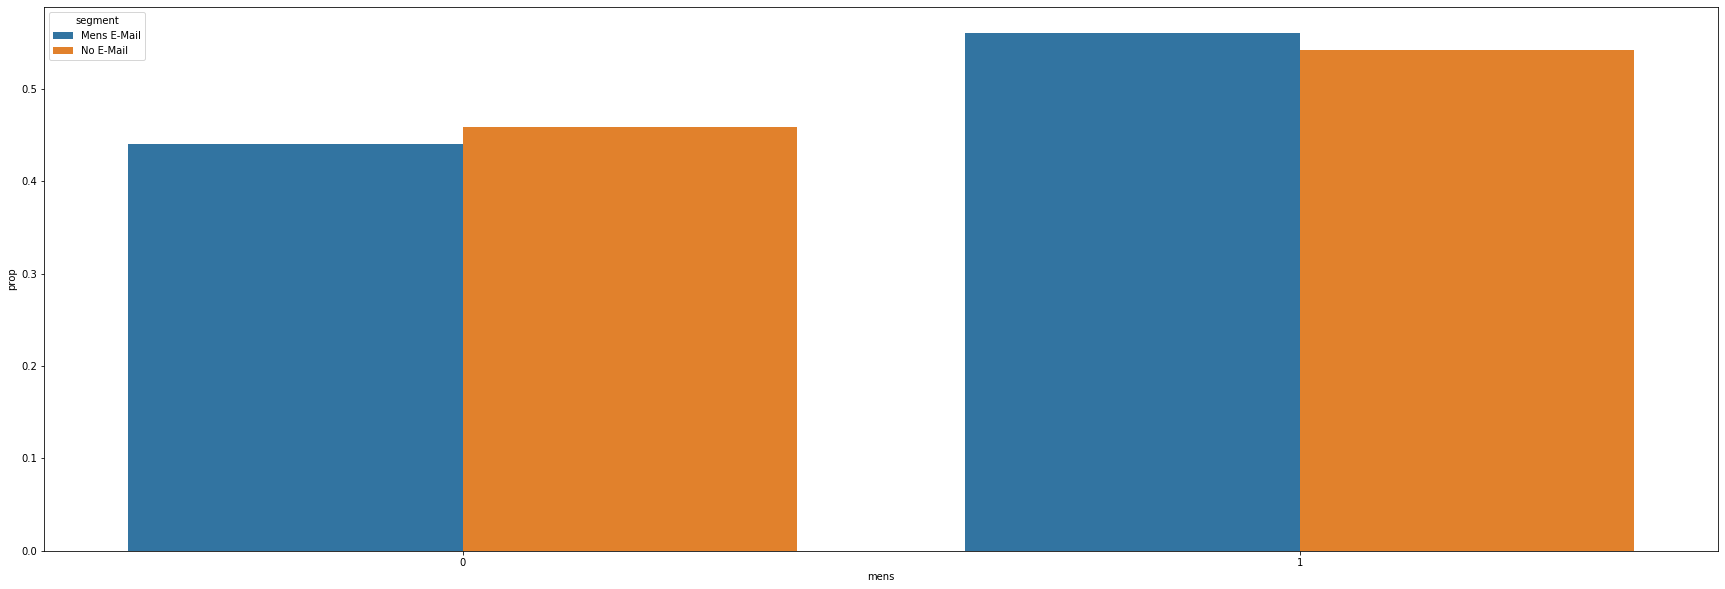

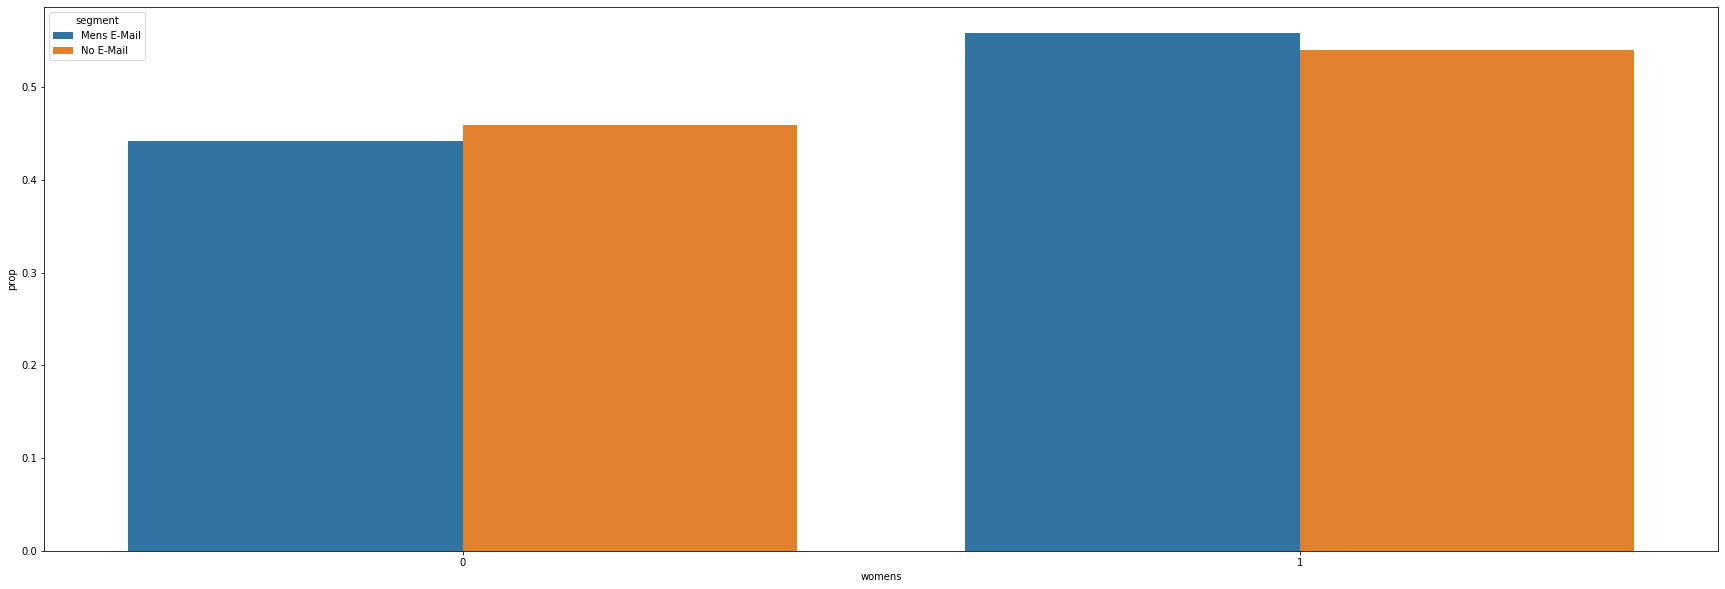

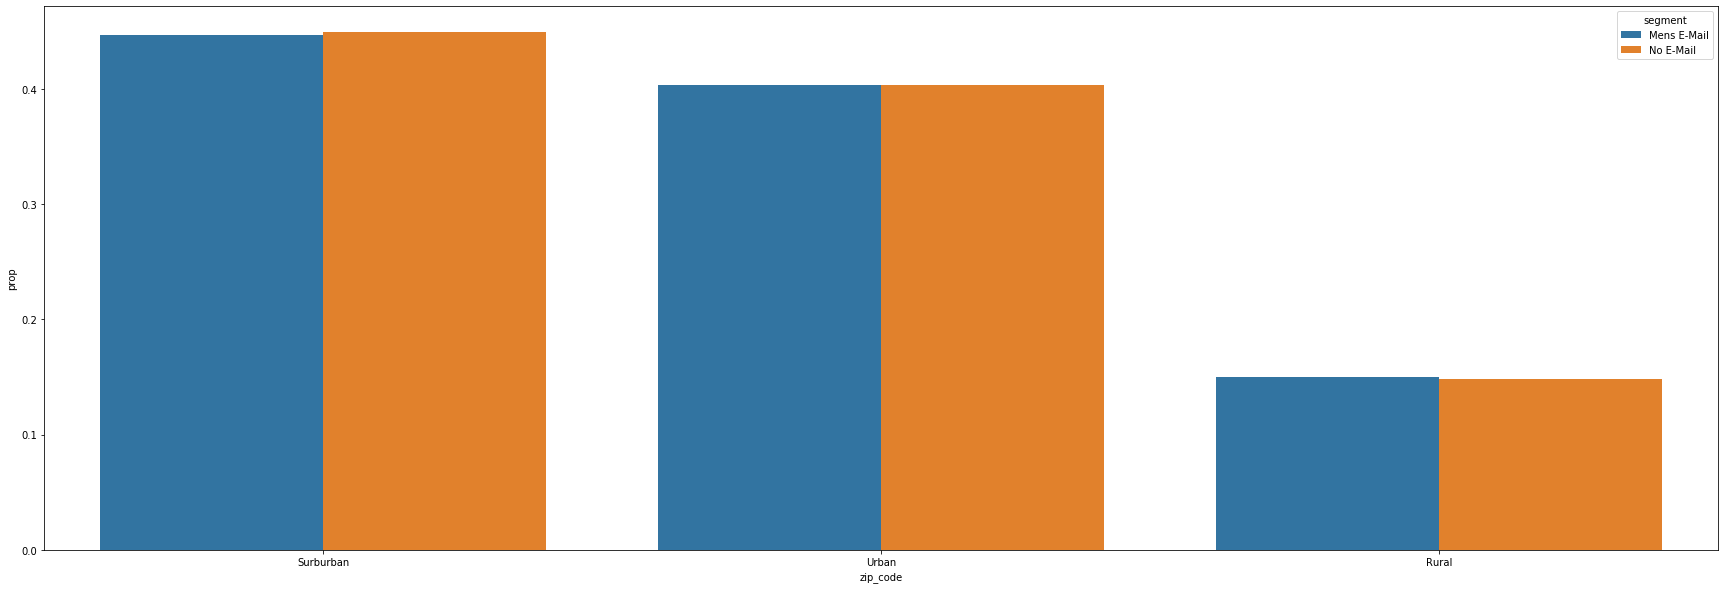

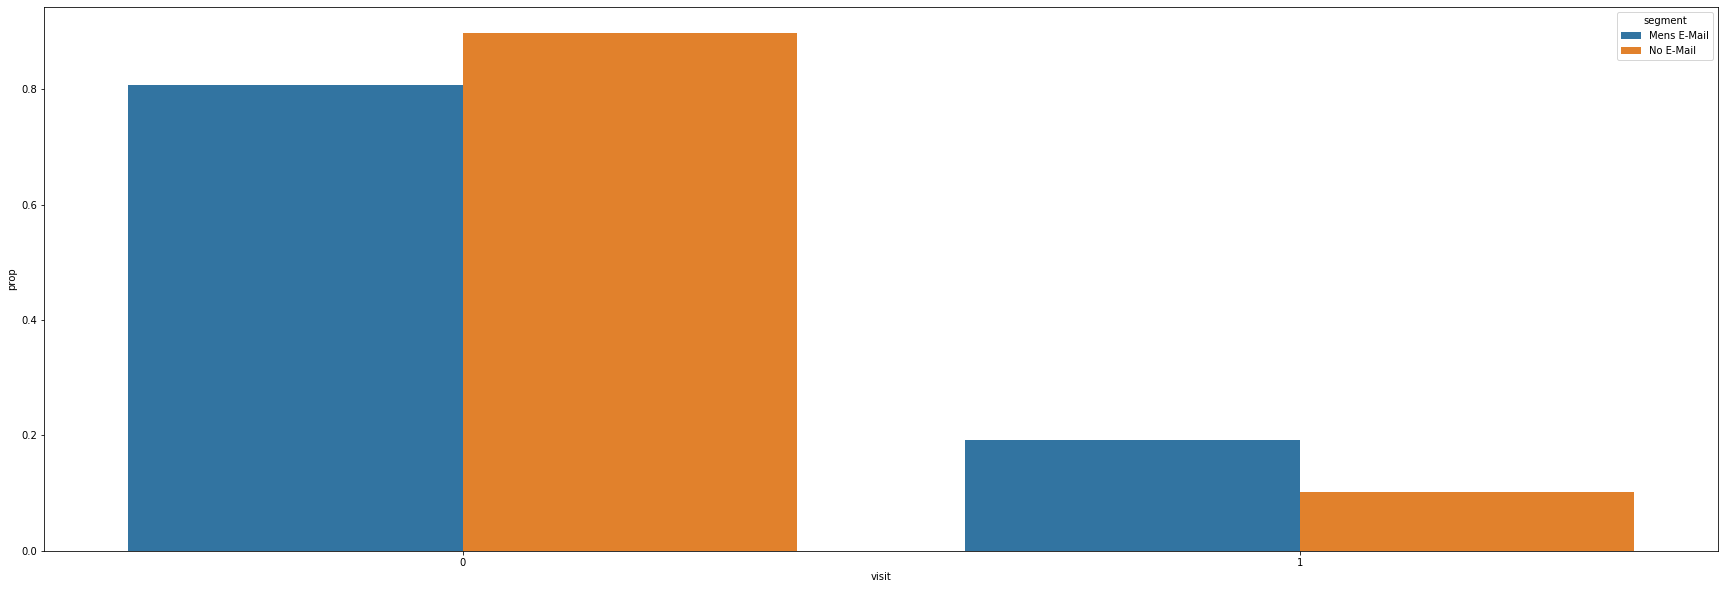

In [49]:
columns = ['recency', 'history_segment', 'mens', 'womens', 'zip_code', 'visit']
hue = 'segment'
y = 'prop'

for i, column in enumerate(columns):
    fig, axs = plt.subplots(1, 1, figsize=(30,10))
    if column == 'history_segment':
        order = sorted(list(set(biased_data['history_segment'])))
    else:
        order = None
        
        
    
    prop_df = (biased_data.groupby("segment")[column]
               .value_counts(normalize=True)
               .rename(y)
               .reset_index())
    
    sns.barplot(x=column, y=y, hue = hue, data=prop_df, ax=axs)

historyの分布

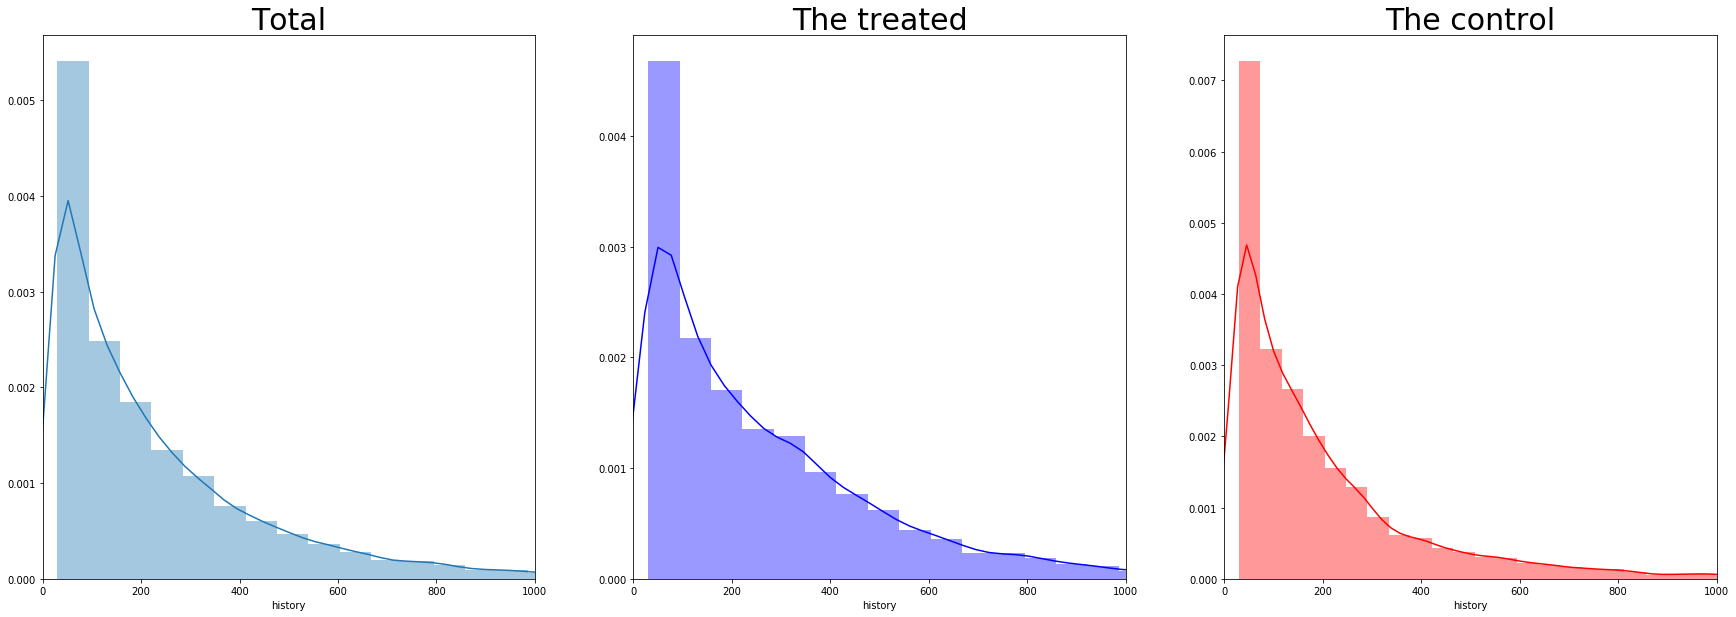

In [50]:
columns = ['history']
for i, column in enumerate(columns):
    fig, axs = plt.subplots(1, 3, figsize=(30,10))
    sns.distplot(biased_data[column], color="#1f77b4", ax = axs[0]).set_title('Total',fontsize=30)
    sns.distplot(biased_data[biased_data['treatment'] >= .5][column], color="blue", ax = axs[1]).set_title('The treated',fontsize=30)
    sns.distplot(biased_data[biased_data['treatment'] < .5][column], color="red", ax = axs[2]).set_title('The control',fontsize=30)
    for j in range(0, 3):
        axs[j].set_xlim(0, 1000)
    plt.show()

セレクションバイアスのあるデータで平均を比較

In [51]:
biased_data.groupby('treatment').agg({'spend': 'mean', 'conversion': ['mean', 'count']})

spend conversion       
               mean       mean  count
treatment                            
0          0.660392   0.005632  11009
1          1.566349   0.012916  10297

(9) Statsmodels のクラスである CompareMeans を使って t検定を行う(Biased)

(a) 男性向けメールが配信されたグループの購買データを得る。

In [52]:
mens_mail_biased = biased_data.loc[biased_data['treatment'] == 1, 'spend']
#mens_mail_biased.hist(bins=100)
mens_mail_biased.describe()

count    10297.000000
mean         1.566349
std         19.529629
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        499.000000
Name: spend, dtype: float64

(b) メールが配信されなかったグループの購買データを得る

In [53]:
no_mail_biased = biased_data.loc[biased_data['treatment'] == 0, 'spend']
#no_mail_biased.hist(bins=100)
no_mail_biased.describe()

count    11009.000000
mean         0.660392
std         11.725775
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        499.000000
Name: spend, dtype: float64

(a)(b)の平均の差に対して有意差検定を実行

In [54]:
rct_ttest_biased = CompareMeans(DescrStatsW(mens_mail_biased), DescrStatsW(no_mail_biased))
rct_ttest_biased.ttest_ind()  # defaults two-sided, pooled
rct_ttest_biased.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,0.9060,0.219,4.135,0.000,0.477,1.335


## 客単価とquantileの評価

客単価どうなっているか念のために見てみる

spend                                                             
           count        mean         std    min    25%     50%     75%    max
treatment                                                                    
0          122.0  114.002705  103.031052  29.99  35.04  88.365  146.17  499.0
1          267.0  113.526929  111.682812  29.99  29.99  66.980  152.72  499.0

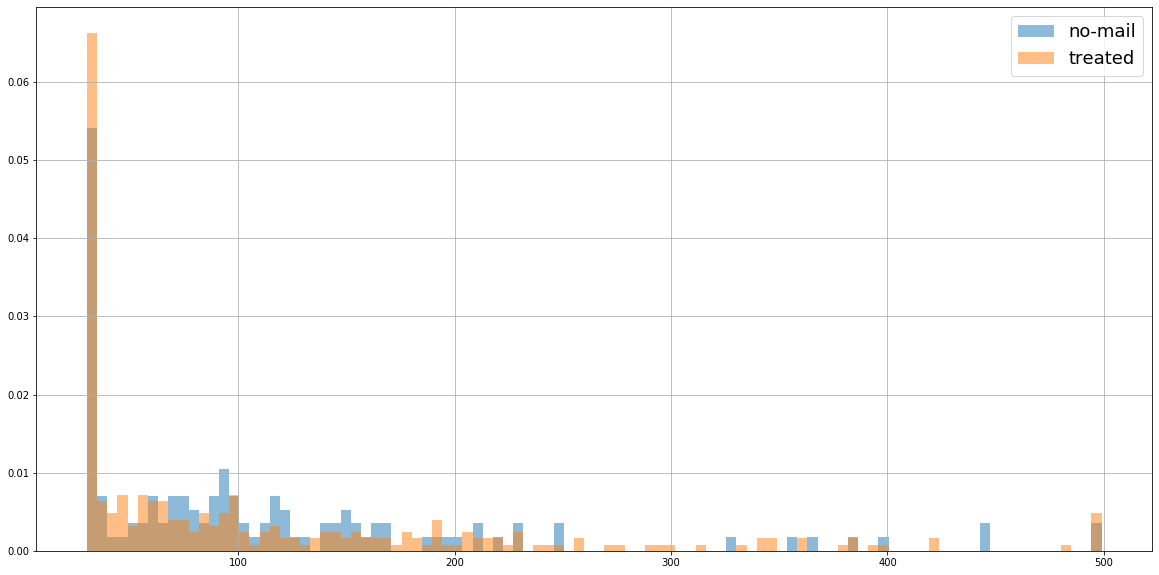

In [55]:
t0_spend = male_df.loc[(male_df['treatment'] == 0) & (male_df['spend'] > 0), 'spend']
t1_spend = male_df.loc[(male_df['treatment'] == 1) & (male_df['spend'] > 0), 'spend']
t0_spend.hist(bins=100, density = True
              , alpha = 0.5, label = 'no-mail', figsize = (20, 10))
t1_spend.hist(bins=100, density = True
              , alpha = 0.5, label = 'treated', figsize = (20, 10))
plt.legend(fontsize=18)


spend_data = male_df[male_df['spend']>0].loc[:,['treatment',
                                                'spend']]
grouped = spend_data.groupby(spend_data['treatment'].astype(str))
grouped.describe().loc[:, ['spend']]

## Appendix: Two-part model

spendはnon-negative randome variableなのでtwo-part modelでも確かめてみます。デメリットとして、latent outcomeを解釈するという、一捻りしなければなんとも実務に繋がらなそうなものになってしまうことが挙げられる。

- [参考](https://data.library.virginia.edu/getting-started-with-hurdle-models/)

Two-part modelはTruncated Regressionの一種。

### Two-part modelの背景
$Y_i$をspendとした時、

$$
\begin{aligned}
E[Y_i|D_i = 1] - E[Y_i|D_i = 0] & = E[Y_i|Y_i>0, D_i = 1]Pr(Y_i > 0 |D_i = 1) \\
& - E[Y_i|Y_i>0, D_i = 0]Pr(Y_i > 0 |D_i = 0) \\
 & =  \{Pr(Y_i > 0 |D_i = 1) - Pr(Y_i > 0 |D_i = 0)\}E[Y_i|Y_i>0, D_i = 1]\\
& + \{E[Y_i|Y_i>0, D_i = 1] - E[Y_i|Y_i>0, D_i = 0]\}Pr(Y_i > 0 |D_i = 0)
\end{aligned}
$$

よってParticipation effecとCOP effectに分解される

COP effectはさらに
$$
\begin{aligned}
E[Y_i|Y_i>0, D_i = 1] - E[Y_i|Y_i>0, D_i = 0] & = E[Y_{1i}|Y_{1i}>0] - E[Y_{0i}|Y_{0i}>0]\\
& = E[Y_{1i} - Y_{0i}|Y_{1i}>0] + E[Y_{0i}|Y_{1i}>0] - E[Y_{0i}|Y_{0i}>0]
\end{aligned}
$$
のようにcausal effectとselection biasに分解される

$$
E[Y_{0i}|Y_{1i}>0] - E[Y_{0i}|Y_{0i}>0]
$$
はnegativeだと推察される（treatmentされなくても買う人は、されて買う人よりももともとロイヤルカスタマーの傾向があるなど）。

#### Poisson modelで実装する

probit modelで実装してみる

model
$$
Y_i = 1[Y_i^* > 0]Y^*_i
$$
where
- $Y_i$: observed outcome
- $Y_i^*$: normally distributed latent variable


推定したいパラメーターは$(\beta, \sigma)$。推定モデルは

$$
\begin{aligned}
E[Y_i|D_i]= & \Phi\left[\frac{\beta_0 + \beta_1 D_i}{\sigma}\right][\beta_0 + \beta_1 D_i]\\
& + \sigma\phi\left[\frac{\beta_0 + \beta_1 D_i}{\sigma}\right]
\end{aligned}
$$

Then,

$$
L(\beta, \sigma|y, X) = \Pi_{i = 1}^N\left[\frac{1}{\sigma}\phi\left(\frac{y_i - x_i'\beta}{\sigma}\right)\right]^{Z_i}\cdot\Phi\left(\frac{y_i - x_i'\beta}{\sigma}\right)^{(1 - Z_i)}
$$


In [56]:
import warnings
warnings.simplefilter('ignore')

In [57]:
def log_lik_hurdle(beta, y, X):
    mu = (y - X @ beta[:-1])/beta[-1]
    indicator = [1 if i > 0.00 else 0 for i in y]
    ones = np.array([1]*len(y))
    sigma = 1/beta[-1] if 1/beta[-1] > 0 else np.nan
    
    return - np.sum(indicator * (np.log(sigma * scipy.stats.norm.pdf(mu))) + (ones - indicator)*np.log(scipy.stats.norm.cdf(mu)))

In [58]:
def estimation(y, X, initial_val, model):
    #def cons(x):
    #    return (x[-1] - 1)
    #
    #cons = (
    #{'type': 'ineq', 'fun': cons}
    #)
    
    opt_res = optimize.minimize(fun = model, 
                            x0 = initial_val, 
                            args = (y, X))
                            #,constraints=cons, method="SLSQP")
    coefficients = opt_res.x
    standard_error = np.sqrt(np.diag(opt_res.hess_inv))
    return (coefficients, standard_error)

In [59]:
### estimation
y = df['spend'].values
hurdle_df = df.loc[:, ['mens', 'treatment']].copy()
hurdle_df['inter_mens_treatment'] = hurdle_df.loc[:, 'mens'] * hurdle_df.loc[:, 'treatment']
hurdle_df['const'] = 1
X = hurdle_df.values
y.shape, X.shape

((64000,), (64000, 4))

In [60]:
col_names = hurdle_df.columns

In [61]:
### OLS
model = sm.OLS(y,X)
results = model.fit()
coef_ols = results.params
error = y - results.predict()
var = np.std(error)
coef_ols = np.append(coef_ols, var)
coef_ols

array([ 0.10325427,  0.2977976 ,  0.47088865,  0.80849734, 15.03307596])

In [62]:
coefficients, std = estimation(y = y, X = X, initial_val = list(coef_ols), model = log_lik_hurdle)
print(col_names)
print(coefficients)
print(std)

Index(['mens', 'treatment', 'inter_mens_treatment', 'const'], dtype='object')
[  -9.92262556   42.88871216   44.79024487 -839.33178307  346.05295339]
[1.07529343 0.61239157 1.62319942 1.46013606 0.46512251]


treatment effect（marginal effect）は

$$
\begin{aligned}
E\left\{\Phi\left[\frac{X_i'\beta^*_0+\beta^*_1D_i}{\sigma}\right]\right\}\cdot\beta^*_1
\end{aligned}
$$


In [63]:
X_mean = X.mean(axis = 0)
X_mean

array([0.55103125, 0.33292187, 0.18342188, 1.        ])

meanで報告する場合

In [64]:
scipy.stats.norm.cdf(np.sum(X_mean * coefficients[:-1])/coefficients[-1])*coefficients[1]

0.37506212393671245

統計量の平均で報告する場合

In [65]:
np.sum(scipy.stats.norm.cdf(X @ coefficients[:-1]/coefficients[-1]))/X.shape[0]*coefficients[1]

0.3871780802421742

### REMARK

- Tobitの係数は大きく出る傾向があるのは良いが、marginal effectがnaive t-testより小さいのは想定と異なる。
- すでに買うような人に対して効果がある施策だったということだろうか？それとも推定誤差の範囲か？

In [66]:
from IPython.display import HTML
HTML(open("../../configurations/custom.css").read())